## Step 1: Load the Data. Filter Data to Choose Zipcodes. (Texas for Henry)
### *New Variable names for this Final Notebook to make merging of the notebooks amongst group members easier*

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import folium
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima 

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Data Importing
df_raw = pd.read_csv("Zillow_data.csv")

In [3]:
# Data Exploration

print(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB
None


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


The 'RegionName' column is also the zipcodes. Changing the column name to 'Zipcode' to remember better. 

In [4]:
df_raw.rename(columns = {'RegionName':'Zipcode'}, inplace = True) 

In [5]:
# Number of unique zipcodes in this dataset
df_raw.Zipcode.nunique()

14723

In [6]:
df_raw

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [7]:
# Binning our df into geographical US regions
# I will be focusing on Texas (Central US)
df_East = df_raw[df_raw.Zipcode < 50000]
df_Central = df_raw[(df_raw.Zipcode >= 50000) & (df_raw.Zipcode < 80000)]
df_West = df_raw[(df_raw.Zipcode >= 80000)]

In [8]:
print(df_East.shape)
print(df_Central.shape)
print(df_West.shape)

(8256, 272)
(3684, 272)
(2783, 272)


In [9]:
# Now utitlizing the ZipCode database.csv
# This includes zipcodes, latitude, longitude, and population

df_Zipcode = pd.read_csv('zip_code_database.csv')

In [10]:
df_Zipcode.info()
df_Zipcode.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42735 entries, 0 to 42734
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   zip                       42735 non-null  int64  
 1   type                      42735 non-null  object 
 2   decommissioned            42735 non-null  int64  
 3   primary_city              42735 non-null  object 
 4   acceptable_cities         9302 non-null   object 
 5   unacceptable_cities       11673 non-null  object 
 6   state                     42735 non-null  object 
 7   county                    41799 non-null  object 
 8   timezone                  41926 non-null  object 
 9   area_codes                39698 non-null  object 
 10  world_region              333 non-null    object 
 11  country                   42657 non-null  object 
 12  latitude                  42735 non-null  float64
 13  longitude                 42735 non-null  float64
 14  irs_es

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
0,501,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


In [11]:
# Renaming the 'zip' column into 'Zipcode' to match the df_raw column name
df_Zipcode.rename(columns = {'zip': 'Zipcode'}, inplace = True)
df_Zipcode = df_Zipcode[['Zipcode','latitude', 'longitude', 'irs_estimated_population']]
df_Zipcode.head()

,Zipcode,latitude,longitude,irs_estimated_population
0,501,40.81,-73.04,562
1,544,40.81,-73.04,0
2,601,18.16,-66.72,0
3,602,18.38,-67.18,0
4,603,18.43,-67.15,0


## Step 2: Data Preprocessing

In [12]:
df = df_raw.merge(df_Zipcode, on = 'Zipcode')

In [13]:
# master df with lat, long, population
print(df.shape)
df.head()

(14723, 275)


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,41.94,-87.65,54760
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,41.92,-87.65,52800
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590


In [14]:
# Texas Data frame
df_Texas = df[(df.Zipcode >= 75001) & (df.Zipcode < 79942)]
df_Texas


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,161900,162800,162800,162800,162900,163500,164300,29.83,-95.66,99740
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,169600,170900,172300,173300,174200,175400,176200,29.84,-95.73,119990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14372,91640,76941,Mertzon,TX,San Angelo,Irion,14373,NaN,NaN,NaN,...,122200,123500,124700,124300,122600,121600,121600,31.26,-100.82,1320
14472,92897,79313,Anton,TX,Levelland,Hockley,14473,NaN,NaN,NaN,...,56300,58900,61500,63000,63600,63500,63300,33.81,-102.16,1260
14492,92921,79355,Plains,TX,NaN,Yoakum,14493,NaN,NaN,NaN,...,100700,99700,97700,95800,94600,94000,93500,33.19,-102.82,1850
14599,92929,79366,Ransom Canyon,TX,Lubbock,Lubbock,14600,134500.0,134500.0,134400.0,...,251500,251300,251500,251700,252500,255000,257500,33.53,-101.69,1120


In [15]:
# Visualizing the Zipcodes on a map
latlongs = df_Texas.filter(['Zipcode', 'latitude', 'longitude'], axis = 1)
latlongs

,Zipcode,latitude,longitude
1,75070,33.17,-96.70
2,77494,29.74,-95.83
4,79936,31.78,-106.30
5,77084,29.83,-95.66
8,77449,29.84,-95.73
...,...,...,...
14372,76941,31.26,-100.82
14472,79313,33.81,-102.16
14492,79355,33.19,-102.82
14599,79366,33.53,-101.69


In [16]:
Texas_Map = folium.Map([33.17, -96.7],zoom_start=7, width='50%')
#location
for lat,lon in zip(latlongs['latitude'],latlongs['longitude']):
     folium.CircleMarker([lat, lon], radius=3).add_to(Texas_Map)
Texas_Map


### Engineering the ROI column. 
Group members decided that 5 year ROI metric will be used. 

In [17]:
df_Texas['3_yr_ROI'] = (df_Texas['2018-04'] - df_Texas['2015-05'])/(df_Texas['2015-05'])
df_Texas['5_yr_ROI'] = (df_Texas['2018-04'] - df_Texas['2013-05'])/(df_Texas['2013-05'])
df_Texas['10_yr_ROI'] = (df_Texas['2018-04'] - df_Texas['2008-05'])/(df_Texas['2008-05'])

<ipython-input-17-13be413f477a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Texas['3_yr_ROI'] = (df_Texas['2018-04'] - df_Texas['2015-05'])/(df_Texas['2015-05'])
<ipython-input-17-13be413f477a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Texas['5_yr_ROI'] = (df_Texas['2018-04'] - df_Texas['2013-05'])/(df_Texas['2013-05'])
<ipython-input-17-13be413f477a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [18]:
df_Texas.describe()

,RegionID,Zipcode,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,3_yr_ROI,5_yr_ROI,10_yr_ROI
count,989.000000,989.000000,989.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,...,9.890000e+02,9.890000e+02,9.890000e+02,9.890000e+02,989.000000,989.000000,989.000000,989.000000,984.000000,958.000000
mean,93684.565217,77182.719919,5901.627907,109384.639831,109406.885593,109451.377119,109521.504237,109613.983051,109721.504237,109843.538136,...,1.944175e+05,1.955031e+05,1.970234e+05,1.980297e+05,31.128018,-97.281294,22955.625885,0.233295,0.383722,0.332983
std,24239.311929,1372.441463,3922.628245,86500.723167,86513.793243,86556.849806,86627.879676,86735.859278,86867.724516,87019.952982,...,1.312428e+05,1.319607e+05,1.330768e+05,1.338056e+05,1.834289,2.292380,19137.684124,0.143010,0.182930,0.173179
min,90611.000000,75001.000000,2.000000,24500.000000,24400.000000,24400.000000,24400.000000,24300.000000,24400.000000,24400.000000,...,3.910000e+04,3.910000e+04,3.920000e+04,3.960000e+04,25.920000,-106.610000,0.000000,-0.127928,-0.054688,-0.149188
25%,91196.000000,76021.000000,2560.000000,58600.000000,58600.000000,58675.000000,58700.000000,58700.000000,58875.000000,58775.000000,...,1.130000e+05,1.139000e+05,1.150000e+05,1.154000e+05,29.740000,-98.030000,7960.000000,0.135848,0.263448,0.227703
50%,91832.000000,77301.000000,5615.000000,84150.000000,84350.000000,84500.000000,84500.000000,84500.000000,84600.000000,84700.000000,...,1.592000e+05,1.611000e+05,1.626000e+05,1.638000e+05,30.950000,-97.060000,19100.000000,0.213001,0.369831,0.332094
75%,92360.000000,78259.000000,8936.000000,127475.000000,127475.000000,127500.000000,127400.000000,127475.000000,127500.000000,127450.000000,...,2.372000e+05,2.377000e+05,2.397000e+05,2.413000e+05,32.750000,-95.530000,32560.000000,0.311917,0.490385,0.438061
max,422746.000000,79938.000000,14696.000000,772100.000000,765800.000000,760200.000000,755200.000000,751100.000000,747800.000000,745500.000000,...,1.250200e+06,1.258300e+06,1.265800e+06,1.268600e+06,36.010000,-93.660000,125330.000000,0.850000,1.031395,1.111983


In [19]:
# Filtering our Zipcodes. Looking at mean/median estimated population and then using 25% to 75% data.

df_Texas = df_Texas[df_Texas['irs_estimated_population'] >= 20000].reset_index()


In [20]:
#Calculate the 75% cutoff value (1.5 deciles above).
q_75 = df_Texas['2018-04'].quantile(q=0.75)
print(f'Average Value 75% cutoff value: {round(q_75,2)}')
#Calculate the 25% cutoff value (1.5 deciles below).
q_25 = df_Texas['2018-04'].quantile(q=0.25)
print(f'Average Value 25% cutoff value: {round(q_25,2)}')
#Get data frame with selected zipcodes.
df_Texas= df_Texas[(df_Texas['2018-04']<q_75) & (df_Texas['2018-04']>q_25)]


Average Value 75% cutoff value: 275425.0
Average Value 25% cutoff value: 142075.0


In [21]:
df_Texas

,index,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,3_yr_ROI,5_yr_ROI,10_yr_ROI
3,5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,...,162800,162900,163500,164300,29.83,-95.66,99740,0.156228,0.427454,0.287618
4,8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,...,173300,174200,175400,176200,29.84,-95.73,119990,0.206849,0.462241,0.324812
5,18,92593,78660,Pflugerville,TX,Austin,Travis,19,138900.0,138600.0,...,240000,241000,242200,242800,30.44,-97.62,102560,0.251546,0.424047,0.393001
6,22,92036,77573,League City,TX,Houston,Galveston,23,141400.0,141000.0,...,254700,257100,259800,261400,29.48,-95.10,88570,0.211868,0.396368,0.349510
7,23,92045,77584,Pearland,TX,Houston,Brazoria,24,138500.0,138700.0,...,251900,253200,255100,256500,29.55,-95.35,87780,0.171233,0.370192,0.303354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,6329,93074,79765,Odessa,TX,Odessa,Ector,6330,129800.0,129800.0,...,240600,240800,241900,243100,31.91,-102.26,20180,-0.000822,0.137576,0.243478
465,6411,90805,75253,Dallas,TX,Dallas-Fort Worth,Dallas,6412,72100.0,72100.0,...,138500,139600,141400,143200,32.67,-96.61,21270,0.608989,0.792240,0.446465
467,6533,92656,78747,Austin,TX,Austin,Travis,6534,181200.0,180400.0,...,244800,246600,249300,251200,30.13,-97.74,20190,0.256000,0.469865,0.419209
468,6540,91290,76177,Fort Worth,TX,Dallas-Fort Worth,Tarrant,6541,140000.0,140200.0,...,249400,249900,250900,251300,32.98,-97.31,21020,0.221682,0.402344,0.449250


<AxesSubplot:xlabel='irs_estimated_population', ylabel='10_yr_ROI'>

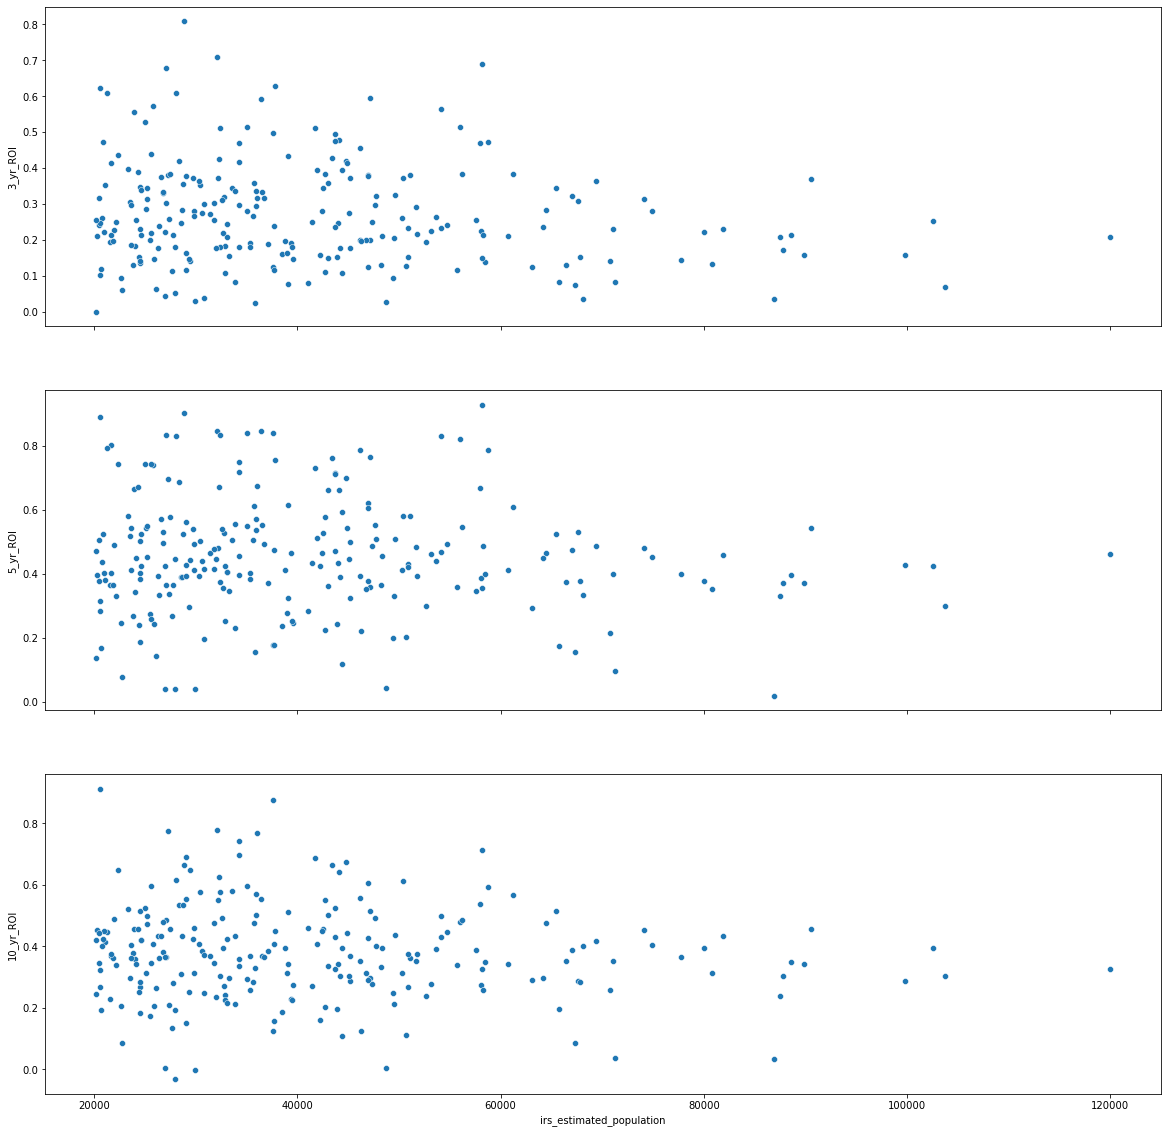

In [22]:
# Visualizing the population vs 5 Year ROI

fig, axs = plt.subplots(3,1, sharex=True, figsize=(20,20))
sns.scatterplot(data=df_Texas, x='irs_estimated_population', y='3_yr_ROI', ax=axs[0])
sns.scatterplot(data=df_Texas, x='irs_estimated_population', y='5_yr_ROI', ax=axs[1])
sns.scatterplot(data=df_Texas, x='irs_estimated_population', y='10_yr_ROI', ax=axs[2])

In [23]:
# Helpful functions to find the average 5 year ROI over the years

def average_three_year_ROI(df):
    b=6
    avg_three_year_ROI = []
    for i in range(len(df)):
        avg_ROI3 = []
        for j in range(b):
            avg_ROI_3 = round(100*(df.iloc[i, 271-(j)*12] - df.iloc[i, 271-(j+3)*12] )/ df.iloc[i, 271-(j+3)*12],2)
            avg_ROI3.append(avg_ROI_3)
        avg_three_year_ROI.append(sum(avg_ROI3)/b)
    return avg_three_year_ROI 

def average_five_year_ROI(df):
    b=4
    avg_five_year_ROI = []
    for i in range(len(df)):
        avg_ROI5 = []
        for j in range(b):
            avg_ROI_5 = round(100*(df.iloc[i, 271-(j)*12] - df.iloc[i, 271-(j+5)*12] )/ df.iloc[i, 271-(j+5)*12],2)
            avg_ROI5.append(avg_ROI_5)
        avg_five_year_ROI.append(sum(avg_ROI5)/b)
    return avg_five_year_ROI

def average_ten_year_ROI(df):
    b=1
    avg_ten_year_ROI = []
    for i in range(len(df)):
        avg_ROI10 = []
        for j in range(b):
            avg_ROI_10 = round(100*(df.iloc[i, 271-(j)*12] - df.iloc[i, 271-(j+10)*12] )/ df.iloc[i, 271-(j+10)*12],2)
            avg_ROI10.append(avg_ROI_10)
        avg_ten_year_ROI.append(sum(avg_ROI10)/b)
    return avg_ten_year_ROI

In [24]:
df_Texas['avg_3_yr_ROI'] = average_three_year_ROI(df_Texas)
df_Texas['avg_5_yr_ROI'] = average_five_year_ROI(df_Texas)
df_Texas['avg_10_yr_ROI'] = average_ten_year_ROI(df_Texas)

In [86]:
df_Texas

%store df_Texas

Stored 'df_Texas' (DataFrame)


In [26]:
df_Texas.describe()

,index,RegionID,Zipcode,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2018-04,latitude,longitude,irs_estimated_population,3_yr_ROI,5_yr_ROI,10_yr_ROI,avg_3_yr_ROI,avg_5_yr_ROI,avg_10_yr_ROI
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,...,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,2426.621849,96920.869748,77102.180672,2427.621849,106207.983193,106102.941176,106032.773109,106001.680672,106007.983193,106035.714286,...,201628.991597,31.007773,-97.079790,41412.941176,0.271341,0.454030,0.381034,16.782689,29.999475,35.703529
std,1845.701646,39676.139731,1295.617731,1845.701646,24176.483224,24023.914592,23902.815219,23810.640047,23747.633667,23703.298425,...,37596.866170,1.599407,1.942553,18386.757129,0.144568,0.182014,0.156372,5.340387,9.696454,15.330589
min,5.000000,90613.000000,75006.000000,6.000000,57200.000000,57300.000000,57300.000000,57400.000000,57500.000000,57600.000000,...,142300.000000,26.270000,-106.610000,20180.000000,-0.000822,0.019027,-0.032967,-0.001667,-0.012500,-5.220000
25%,791.500000,91213.250000,76052.250000,792.500000,87425.000000,87050.000000,86750.000000,87150.000000,87500.000000,87500.000000,...,171850.000000,29.660000,-97.665000,27370.000000,0.172414,0.357251,0.285666,14.192500,25.054375,26.210000
50%,1939.000000,91852.500000,77338.500000,1940.000000,102800.000000,102850.000000,102900.000000,103000.000000,103150.000000,103100.000000,...,195450.000000,30.330000,-96.985000,36260.000000,0.246705,0.437592,0.367859,16.832500,30.730000,34.885000
75%,3848.250000,92311.250000,78154.750000,3849.250000,124750.000000,124600.000000,124400.000000,124400.000000,124475.000000,124525.000000,...,231900.000000,32.690000,-95.562500,49497.500000,0.356670,0.542100,0.457817,19.853750,35.329375,43.272500
max,6853.000000,399726.000000,79938.000000,6854.000000,181200.000000,180400.000000,179600.000000,178700.000000,177800.000000,176800.000000,...,275100.000000,35.170000,-94.130000,119990.000000,0.808057,0.926645,0.912354,30.556667,56.130000,89.610000


## Data Visualizations

In [27]:
# Top 5 zipcodes in terms of 5 year ROI
df_Texas.sort_values('5_yr_ROI',ascending=False).head()[['Zipcode','City','State','5_yr_ROI',  'irs_estimated_population']]


,Zipcode,City,State,5_yr_ROI,irs_estimated_population
33,75228,Dallas,TX,0.926645,58190
342,75224,Dallas,TX,0.900374,28820
273,78212,San Antonio,TX,0.890264,20620
135,76112,Fort Worth,TX,0.846154,36450
286,75234,Farmers Branch,TX,0.843972,32060


In [28]:
# Top 5 zipcodes in terms of Average 5 year ROI
df_Texas.sort_values('avg_5_yr_ROI',ascending=False).head()[['Zipcode','City','State','avg_5_yr_ROI',  'irs_estimated_population']]

,Zipcode,City,State,avg_5_yr_ROI,irs_estimated_population
165,77080,Houston,TX,56.1300,36070
55,78758,Austin,TX,55.9650,37620
217,77092,Houston,TX,51.3325,27250
57,78741,Austin,TX,51.2025,34220
33,75228,Dallas,TX,49.0450,58190


(array([ 0., 10., 20., 30., 40., 50., 60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

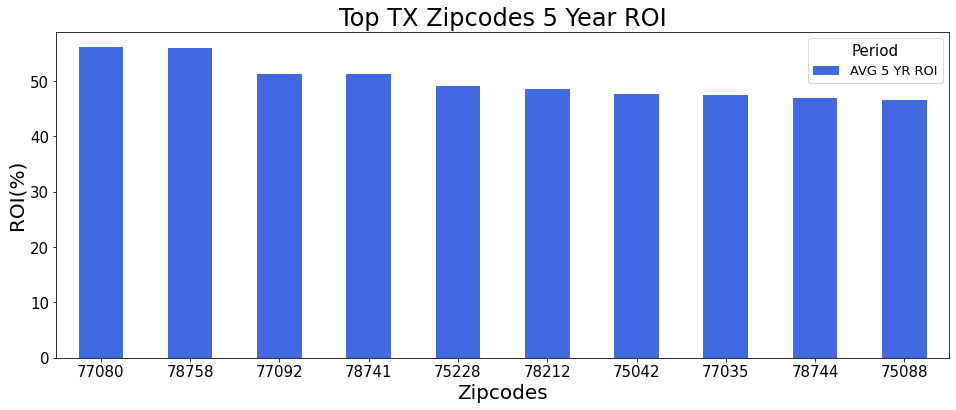

In [29]:
ax = df_Texas.sort_values('avg_5_yr_ROI',ascending=False).head(10).plot(x="Zipcode", y='avg_5_yr_ROI', kind="bar", figsize=(16,6), label = "AVG 5 YR ROI", color = "royalblue")

plt.title('Top TX Zipcodes 5 Year ROI', size=24)
plt.legend(loc='best', title='Period',  title_fontsize=15, fontsize=13)
plt.xlabel('Zipcodes', size=20)
plt.xticks(rotation='horizontal', fontsize=15)
plt.ylabel('ROI(%)', size=20)
plt.yticks(fontsize = 15)

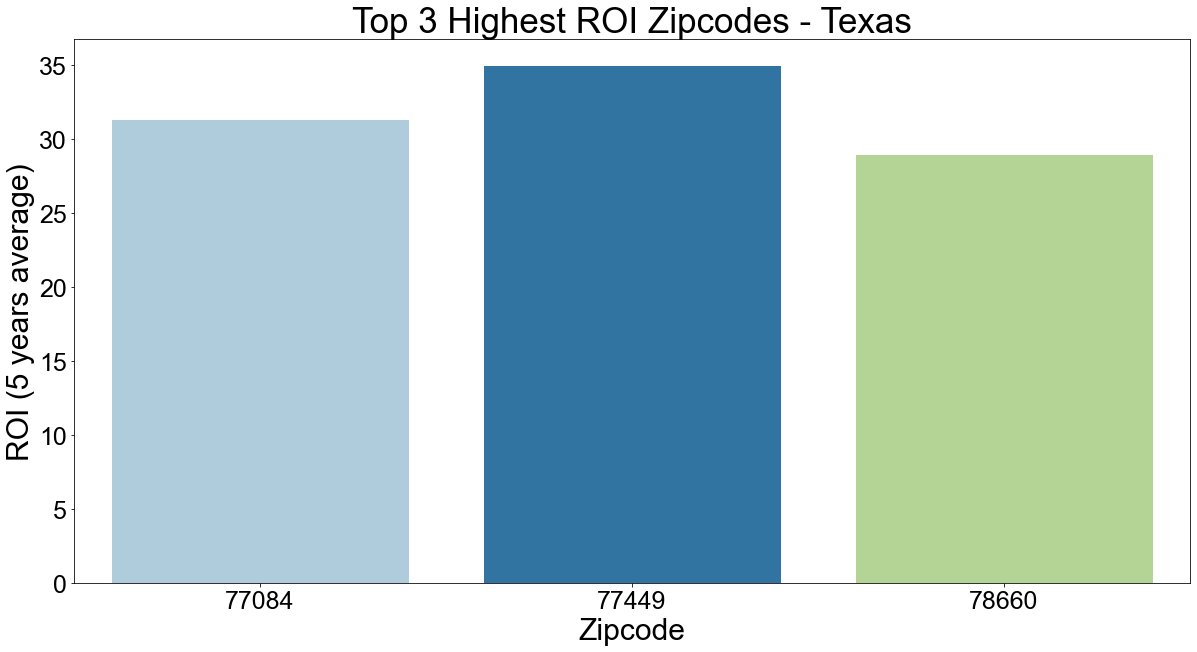

In [30]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.set(style = 'white')
palette = sns.set_palette(sns.color_palette("Paired"))
p = sns.barplot(x = "Zipcode", y = 'avg_5_yr_ROI', data = df_Texas[:3], color = palette)
p.set_xlabel("Zipcode", fontsize = 30)
p.set_ylabel("ROI (5 years average)", fontsize = 30)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
p.set_title("Top 3 Highest ROI Zipcodes - Texas", fontsize = 35)

plt.show()

We now have our top Texas Zipcodes. 77080(Houston), 78758(Austin), 77092(Houston) are our top 3. 

# Step 3: More EDA and Visualizations

font = {'family' : 'normal', 'weight' : 'bold', 'size' : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [31]:
Texas_Top_3 = df_Texas.sort_values('avg_5_yr_ROI',ascending=False, ignore_index = True).head(3)
Texas_Top_3 = Texas_Top_3.drop(columns = [ 'index', 'RegionID','Metro','CountyName','SizeRank'])
Texas_Top_3

,Zipcode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2018-04,latitude,longitude,irs_estimated_population,3_yr_ROI,5_yr_ROI,10_yr_ROI,avg_3_yr_ROI,avg_5_yr_ROI,avg_10_yr_ROI
0,77080,Houston,TX,107400.0,106100.0,105100.0,104200.0,103500.0,103000.0,102800.0,...,254600,29.82,-95.52,36070,0.316443,0.673899,0.766829,29.831667,56.1300,75.95
1,78758,Austin,TX,129000.0,128300.0,127500.0,126900.0,126300.0,125800.0,125300.0,...,270400,30.39,-97.71,37620,0.496403,0.838205,0.876475,30.556667,55.9650,84.85
2,77092,Houston,TX,95600.0,96900.0,98400.0,99900.0,101500.0,103000.0,104200.0,...,249300,29.83,-95.47,27250,0.378872,0.694765,0.773115,28.326667,51.3325,76.58


In [32]:
Texas_latlongs3 = Texas_Top_3.filter(['Zipcode', 'latitude', 'longitude'], axis=1)

Texas_Map = folium.Map([29.82, -95.52],zoom_start=7, width='50%')
#location
for lat,lon in zip(Texas_latlongs3['latitude'],Texas_latlongs3['longitude']):
     folium.CircleMarker([lat, lon], radius=6).add_to(Texas_Map)
Texas_Map

In [33]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[:], format='%Y-%m')

In [34]:
Zip_77080 = Texas_Top_3[:1]
Zip_78758 = Texas_Top_3[1:2]
Zip_77092 = Texas_Top_3[2:3]

In [35]:
Zip_77080

,Zipcode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2018-04,latitude,longitude,irs_estimated_population,3_yr_ROI,5_yr_ROI,10_yr_ROI,avg_3_yr_ROI,avg_5_yr_ROI,avg_10_yr_ROI
0,77080,Houston,TX,107400.0,106100.0,105100.0,104200.0,103500.0,103000.0,102800.0,...,254600,29.82,-95.52,36070,0.316443,0.673899,0.766829,29.831667,56.13,75.95


# Step 4: Reshape from Wide to Long Format. 
Utlizing the helper function melt_data

In [36]:
def melt_data(dfs):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    melted_list = []
    for df in dfs:
        melted = pd.melt(df, id_vars=['Zipcode', 'City', 'State', 'latitude', 'longitude', 'irs_estimated_population', '3_yr_ROI', '5_yr_ROI', '10_yr_ROI' , 'avg_3_yr_ROI','avg_5_yr_ROI','avg_10_yr_ROI'], var_name='Date')
        melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
        melted = melted.dropna(subset=['value'])
        melted_list.append(melted.groupby('Date').aggregate({'value':'mean'}))
    return melted_list

In [37]:
# Passing in the Top 3 Texas Zipcodes into the melt_data function. 
zips_to_melt = [Zip_77080, Zip_78758, Zip_77092]
zip_77080_melted, zip_78758_melted, zip_77092_melted = melt_data(zips_to_melt)

In [38]:
zip_77080_melted

,value
Date,
1996-04-01,107400.0
1996-05-01,106100.0
1996-06-01,105100.0
1996-07-01,104200.0
1996-08-01,103500.0
...,...
2017-12-01,248800.0
2018-01-01,250100.0
2018-02-01,251900.0


In [39]:
Zip_77080_melted,Zip_78758_melted,Zip_77092_melted = zip_77080_melted['2010-01-01':],zip_78758_melted['2010-01-01':],zip_77092_melted['2010-01-01':]


In [40]:
#Melted data from 04/01/1996
Texas_all_Zip_Melted = pd.concat([zip_77080_melted,zip_78758_melted,zip_77092_melted], axis=1)
Texas_all_Zip_Melted.columns = ['Zip_77080','Zip_78758','Zip_77092']
Texas_all_Zip_Melted

,Zip_77080,Zip_78758,Zip_77092
Date,,,
1996-04-01,107400.0,129000.0,95600.0
1996-05-01,106100.0,128300.0,96900.0
1996-06-01,105100.0,127500.0,98400.0
1996-07-01,104200.0,126900.0,99900.0
1996-08-01,103500.0,126300.0,101500.0
...,...,...,...
2017-12-01,248800.0,250500.0,246000.0
2018-01-01,250100.0,255100.0,246900.0
2018-02-01,251900.0,260100.0,247300.0


In [41]:
#Melted data from 01/01/2010
Texas_All_Zip_Melted = pd.concat([Zip_77080_melted['2010-01-01':],Zip_78758_melted['2010-01-01':],Zip_77092_melted['2010-01-01':]], axis=1)
Texas_All_Zip_Melted.columns = ['Zip_77080','Zip_78758','Zip_77092']
Texas_All_Zip_Melted

,Zip_77080,Zip_78758,Zip_77092
Date,,,
2010-01-01,146900.0,142900.0,141800.0
2010-02-01,147200.0,143000.0,142200.0
2010-03-01,147000.0,143300.0,141500.0
2010-04-01,145200.0,143700.0,139100.0
2010-05-01,142700.0,144200.0,138200.0
...,...,...,...
2017-12-01,248800.0,250500.0,246000.0
2018-01-01,250100.0,255100.0,246900.0
2018-02-01,251900.0,260100.0,247300.0


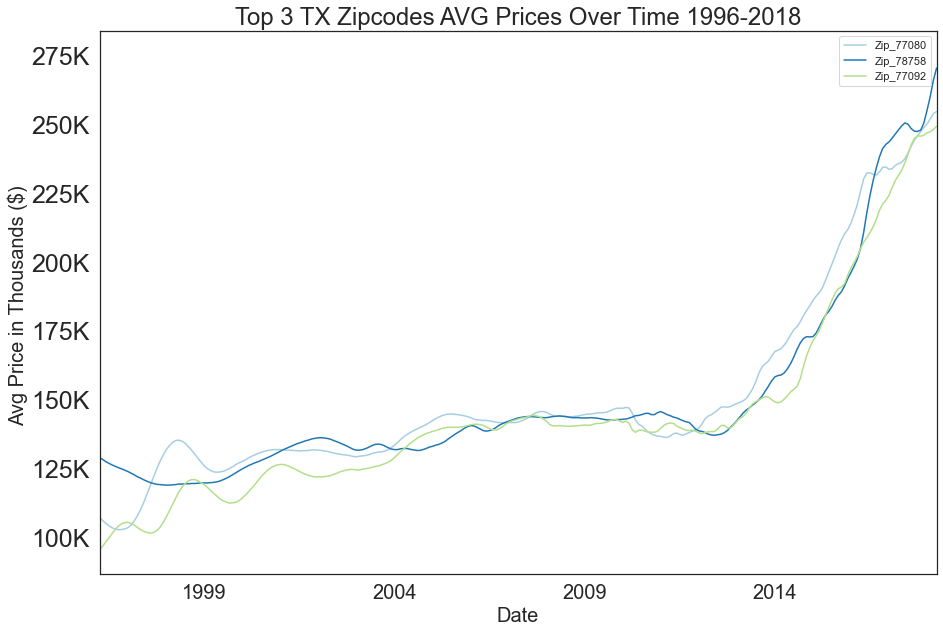

In [42]:
# Visualizing data from 1996 - 2018

#Changing Line Colors
colors = {'Zip_77080': 'blue', 'Zip_78758': 'green', 'Zip_77092': 'red'}
ax =Texas_all_Zip_Melted.plot(figsize = (15,10), subplots = False, legend = True)
plt.title('Top 3 TX Zipcodes AVG Prices Over Time 1996-2018', size=24)
plt.xlabel('Date', size=20)
plt.xticks(rotation='horizontal', fontsize=20)
plt.ylabel('Avg Price in Thousands ($) ', size=20)
plt.yticks([100000,125000,150000,175000,200000,225000, 250000, 275000],
           ["100K", "125K", "150K", "175K", "200K", "225K", "250K", "275K"], fontsize = 25)
plt.plot([1996, 2018], [100000, 275000])


plt.legend(loc = 'upper right')

<AxesSubplot:xlabel='Date'>

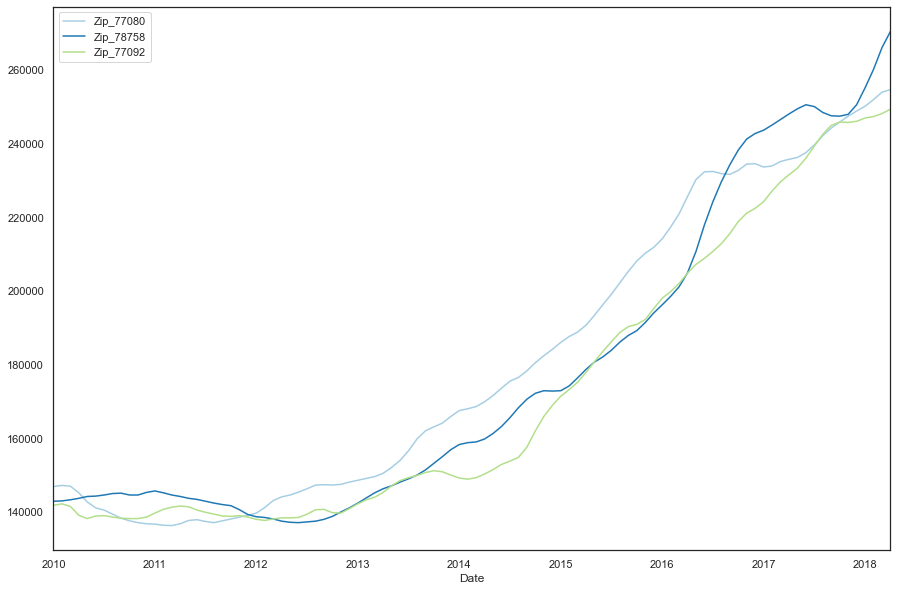

In [43]:
# Visualizing data from 2010
Texas_All_Zip_Melted.plot(figsize = (15,10), subplots = False, legend = True)

# Step 5: ARIMA Modeling

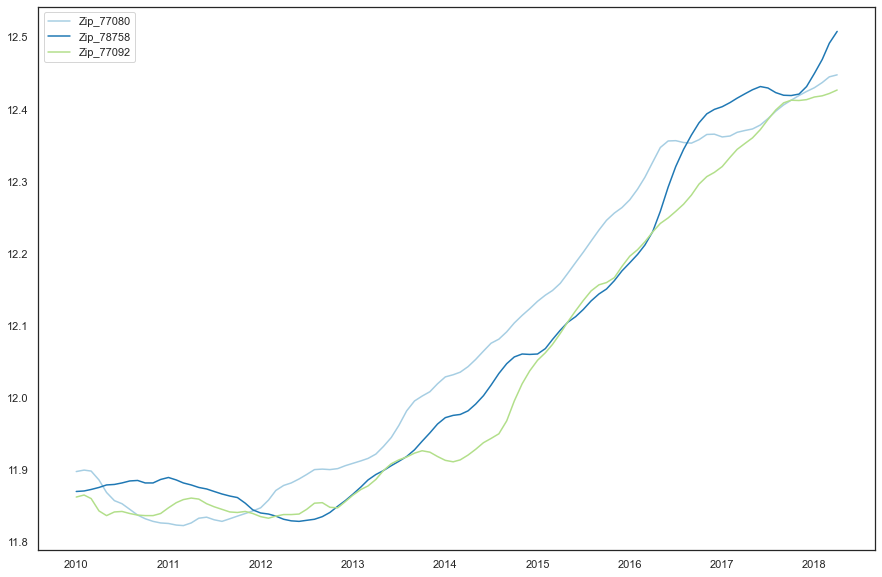

In [44]:
# Data Visualization
# utlizing np.log in this plot
plt.figure(figsize=(15, 10))
plt.plot(np.log(Texas_All_Zip_Melted))
plt.legend(Texas_All_Zip_Melted, loc='upper left')

In [45]:
# Stationarity check function (Dickey Fuller Testing)
def stationarity_check(df):
    """Calculate rolling statistics and plot against original time series, perform and output Dickey Fuller test."""
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = df.rolling(window=24, center=False).mean()
    roll_std = df.rolling(window=24, center=False).std()
        
    # Perform the Dickey Fuller Test
    dftest = adfuller(df)
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean.dropna(), color='red', label='Rolling Mean')
    plt.plot(roll_std.dropna(), color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
#    plt.savefig('Images/rolling.png')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

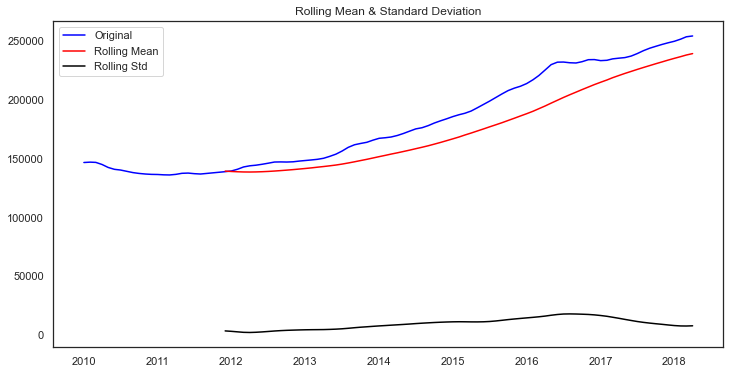

Results of Dickey-Fuller Test: 

Test Statistic                  0.001141
p-value                         0.958626
#Lags Used                      5.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [46]:
# stationarity check of Zipcode77080
stationarity_check(Zip_77080_melted)

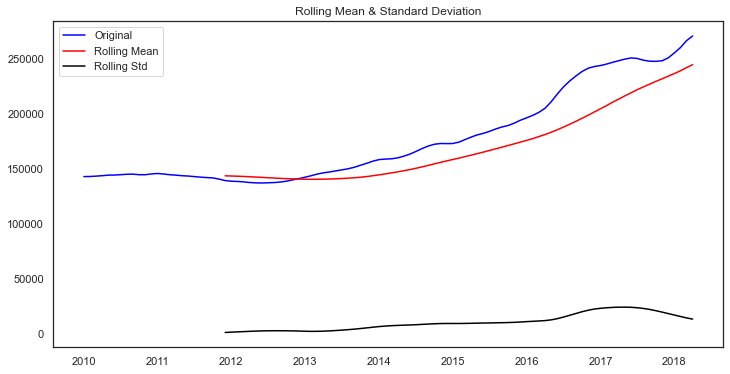

Results of Dickey-Fuller Test: 

Test Statistic                  2.018399
p-value                         0.998696
#Lags Used                     10.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64


In [47]:
# stationarity check of Zipcode78758
stationarity_check(Zip_78758_melted)

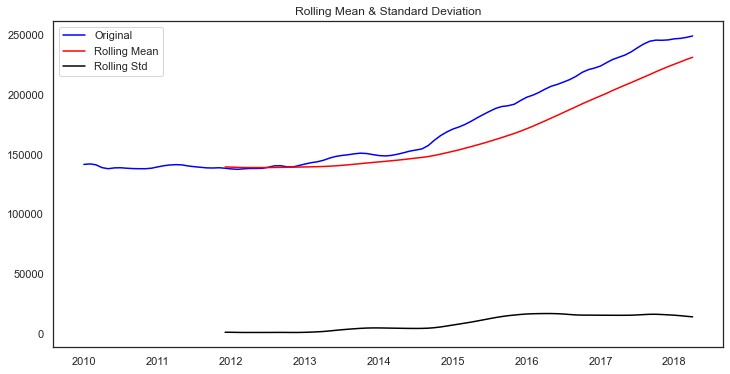

Results of Dickey-Fuller Test: 

Test Statistic                 -0.098239
p-value                         0.949614
#Lags Used                      5.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [48]:
# stationarity check of Zipcode77092
stationarity_check(Zip_77092_melted)

## Interpreting the Dickey-Fuller Test
Null hypothesis in ADF test is that Data is not stationary

It’s better to have the p-value to be smaller than 0.05 inorder to reject the null hypothesis and consider data as stationary

if Test Statistic < Critical Values => Rejects the null hypothesis.

if Test Statistic >Critical Values => failed to reject the null hypothesis.

### In the tests above, the p-values are all larger than the standard 0.05. 
### The Test Statistic values are also larger than the Critical Values
### Thus, data is not stationary. Now we have to transform the data to make it stationary. 

## Differencing Method

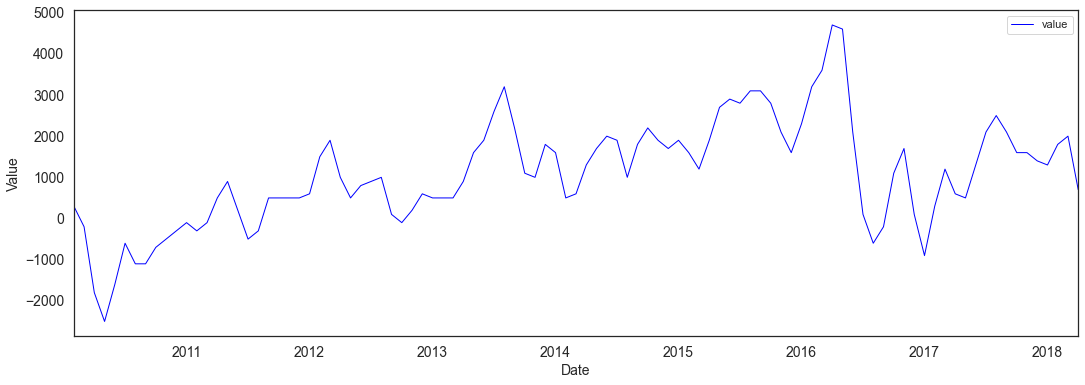

In [49]:
#Differencing Method to make the data stationary

Zip_77080_diff = Zip_77080_melted.diff(periods=1)
Zip_77080_diff.dropna(inplace=True)
Zip_77080_diff.plot(figsize=(18,6), color='blue', linewidth=1, fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14);

In [50]:
def find_best_difference(data):
    for i in range(0,25):
        difference = data.diff(periods=i)
        dftest = adfuller(difference[i:])
        print(i,dftest[1])


In [51]:
find_best_difference(Zip_77080_melted)

0 nan
1 0.10062426730204643
2 0.0905252796249294
3 0.06711726165176972
4 0.238378642011214
5 0.28478220035398627
6 0.17223027031557697
7 0.2159137449084696
8 0.3431117793235212
9 0.4145304886399096
10 0.2336828733189515
11 0.27771677110267584
12 0.22888249492964252
13 0.3283197909118572
14 0.36370179740703074
15 0.20981314681388485
16 0.31209068234681214
17 0.517598716562869
18 0.23577447040713784
19 0.2862068058450941
20 0.42167457351014576
21 0.497142335280731
22 0.547306984141053
23 0.6517828820906952
24 0.5967544893516498


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


The results show that the data is not stationary. Now we will make the data stationary utilizing seasonal_decompose

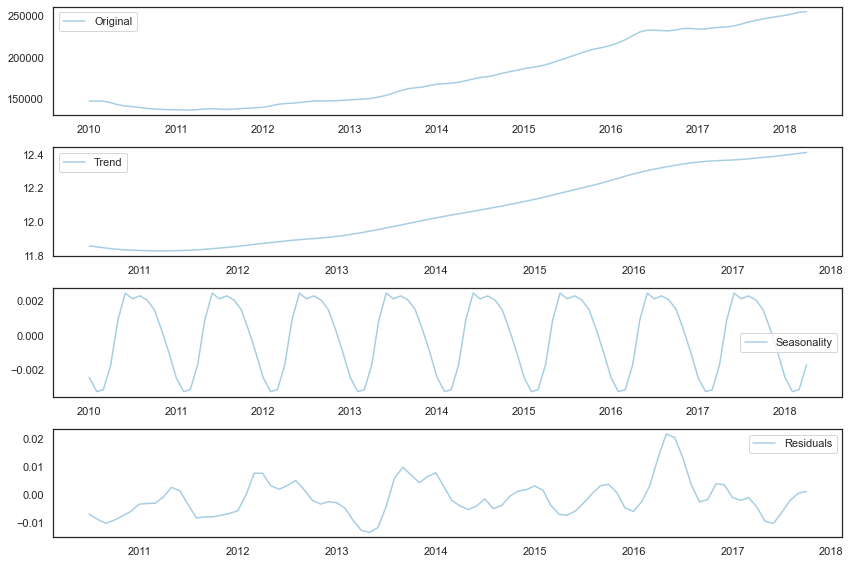

In [52]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(Zip_77080_melted))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Zip_77080_melted, label='Original')#np.log(ts)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
#plt.savefig('Images/decomposition.png')
plt.tight_layout()

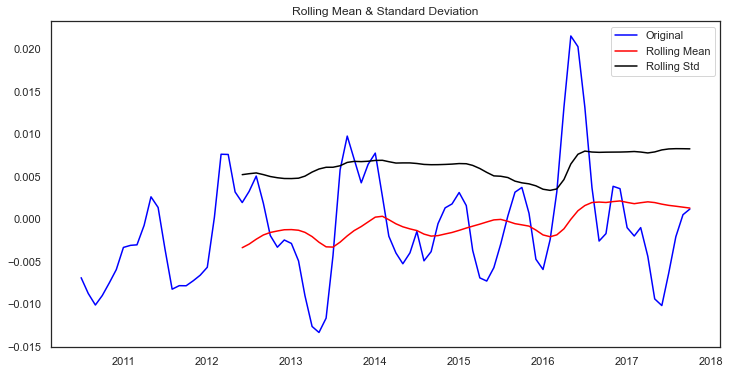

Results of Dickey-Fuller Test: 

Test Statistic                 -4.435343
p-value                         0.000257
#Lags Used                      3.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


In [53]:
# We can drop the missing values from residuals

Zip_77080_residuals = residual
Zip_77080_residuals.dropna(inplace=True)

stationarity_check(Zip_77080_residuals)

Success: The Test Statistic is a lower value than the critical values as well as the p-value being lower than the standard 0.05.

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


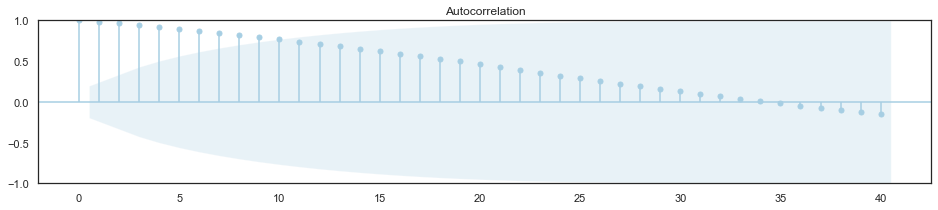

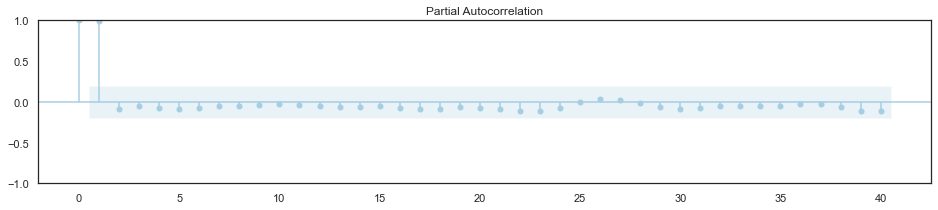

In [54]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(np.log(Zip_77080_melted), ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(np.log(Zip_77080_melted), ax=ax, lags=40);

In [55]:
from statsmodels.tsa.arima.model import ARIMA

In [56]:
Train_set_77080 =np.log(Zip_77080_melted[:'2016-12'])
Val_set_77080 = Zip_77080_melted['2017-01':]

Train_set_78758 = np.log(Zip_78758_melted[:'2016-12'])
Val_set_78758 = Zip_78758_melted['2017-01':]

Train_set_77092 = np.log(Zip_77092_melted[:'2016-12'])
Val_set_77092 = Zip_77092_melted['2017-01':]


In [57]:
##!pip install pmdarima

# Zipcode 77080

## First Model

In [58]:
Texas_Base_model = sm.tsa.statespace.SARIMAX(
    Train_set_77080, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12)).fit(method='powell', disp=False)

Texas_Base_model.summary()

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 270.045
Date:                            Mon, 31 Oct 2022   AIC                           -536.091
Time:                                    20:16:07   BIC                           -531.566
Sample:                                01-01-2010   HQIC                          -534.291
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7417      0.075      9.854      0.000       0.594       0.889
sigma2      2.906e-05   5.04e-06      5.763      0.000    1.92e-05    3.89e-05
===================================================================================
Ljung-Box (L1) (Q):                   7.97   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.00   Prob(JB):                         0.98
Heteroskedasticity (H):               0.52   Skew:                             0.04
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
import pmdarima as pm

auto_model_77080 = pm.auto_arima(Train_set_77080, start_p=0, start_q=0,
#                     test='adf',
                     max_p=5, max_q=10,
                     m=12,
                     d=None,
                     trend = 't',
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=None,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True, with_intercept = True)



print(auto_model_77080.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=-672.129, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[12] intercept   : AIC=-679.943, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[12] intercept   : AIC=-692.281, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-672.129, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=-692.740, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12] intercept   : AIC=-694.017, Time=0.08 sec
 ARIMA(0,2,1)(2,0,0)[12] intercept   : AIC=-691.305, Time=0.25 sec
 ARIMA(0,2,1)(1,0,1)[12] intercept   : AIC=-689.821, Time=0.10 sec
 ARIMA(0,2,1)(2,0,1)[12] intercept   : AIC=-688.477, Time=0.30 sec
 ARIMA(0,2,0)(1,0,0)[12] intercept   : AIC=-673.512, Time=0.11 sec
 ARIMA(1,2,1)(1,0,0)[12] intercept   : AIC=-692.903, Time=0.13 sec
 ARIMA(0,2,2)(1,0,0)[12] intercept   : AIC=-689.937, Time=0.24 sec
 ARIMA(1,2,2)(1,0,0)[12] intercept   : AIC=-700.372, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[12] intercept   : AIC=-699.978, Time=0.12 sec
 ARIMA(1,2,2)(2,0,0

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -2.744e-06   6.88e-06     -0.399      0.690   -1.62e-05    1.07e-05
ar.L1          0.5013      0.099      5.044      0.000       0.306       0.696
ar.L2         -0.6147      0.080     -7.676      0.000      -0.772      -0.458
sigma2      9.176e-06    1.4e-06      6.558      0.000    6.43e-06    1.19e-05


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


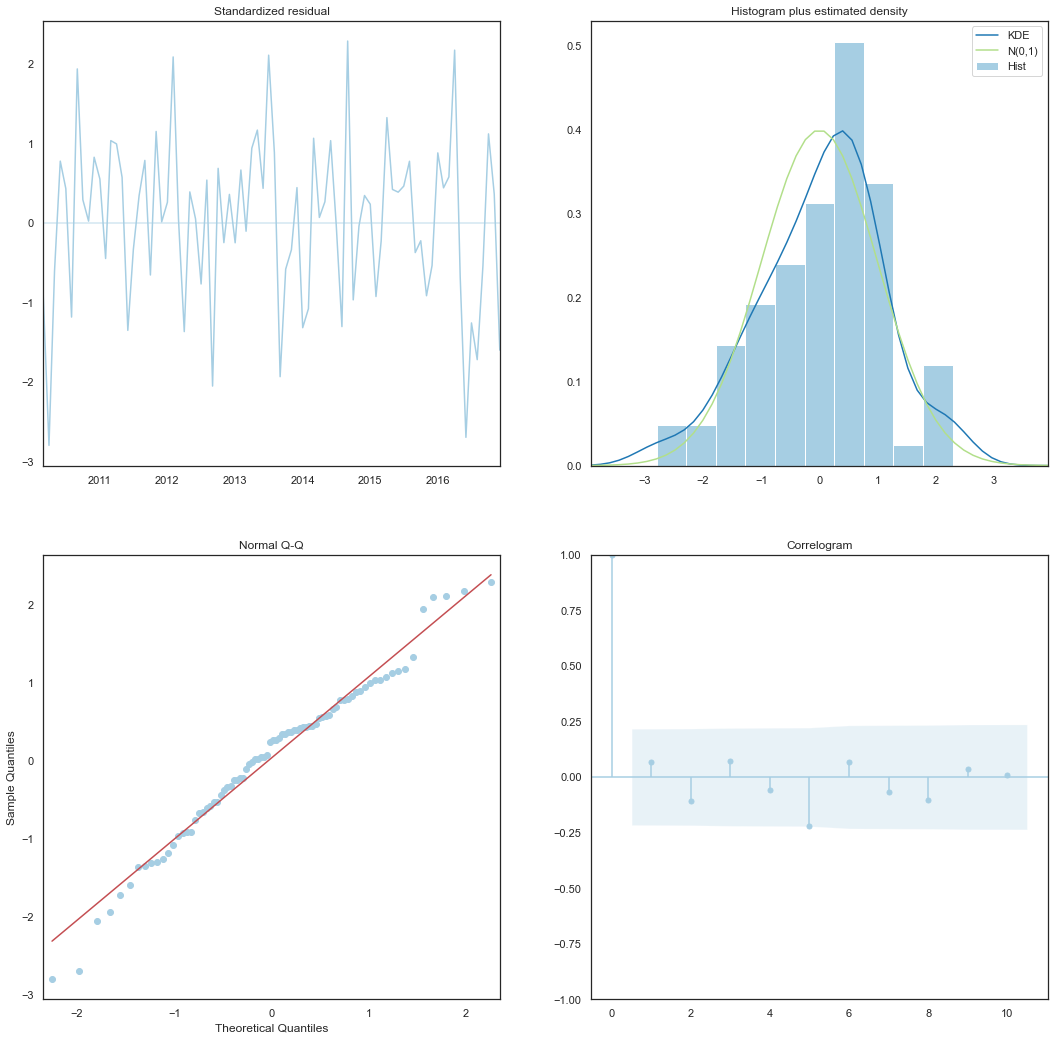

In [60]:
# Enter in the parameters found in best auto ARIMA model
# ARIMA (2,2,0)(0,0,0)[12]
ARIMA_MODEL_77080 = sm.tsa.statespace.SARIMAX(Train_set_77080, 
                                        order=(2,2,0), 
                                        seasonal_order=(0, 0, 0, 12), 
                                        trend = 't',
                                        seasonal = True,
                                        trace=True,
                                        error_action= 'ignore',
                                        suppress_warnings=True,
                                        stepwise=True
#                                        enforce_stationarity=False, 
#                                        enforce_invertibility=False)
)
# Fit the model and print results
output_77080 = ARIMA_MODEL_77080.fit(method='powell', disp=False)

print(output_77080.summary().tables[1])
auto_model_77080.plot_diagnostics(figsize=(18,18))
plt.show()

In [61]:
pred_77080 = output_77080.get_prediction(start='2017-01-01',  end='2018-04-01', dynamic=False)
pred_ci_77080 = np.exp(pred_77080.conf_int())
pred_mean_77080 = np.exp(pred_77080.predicted_mean.to_frame())

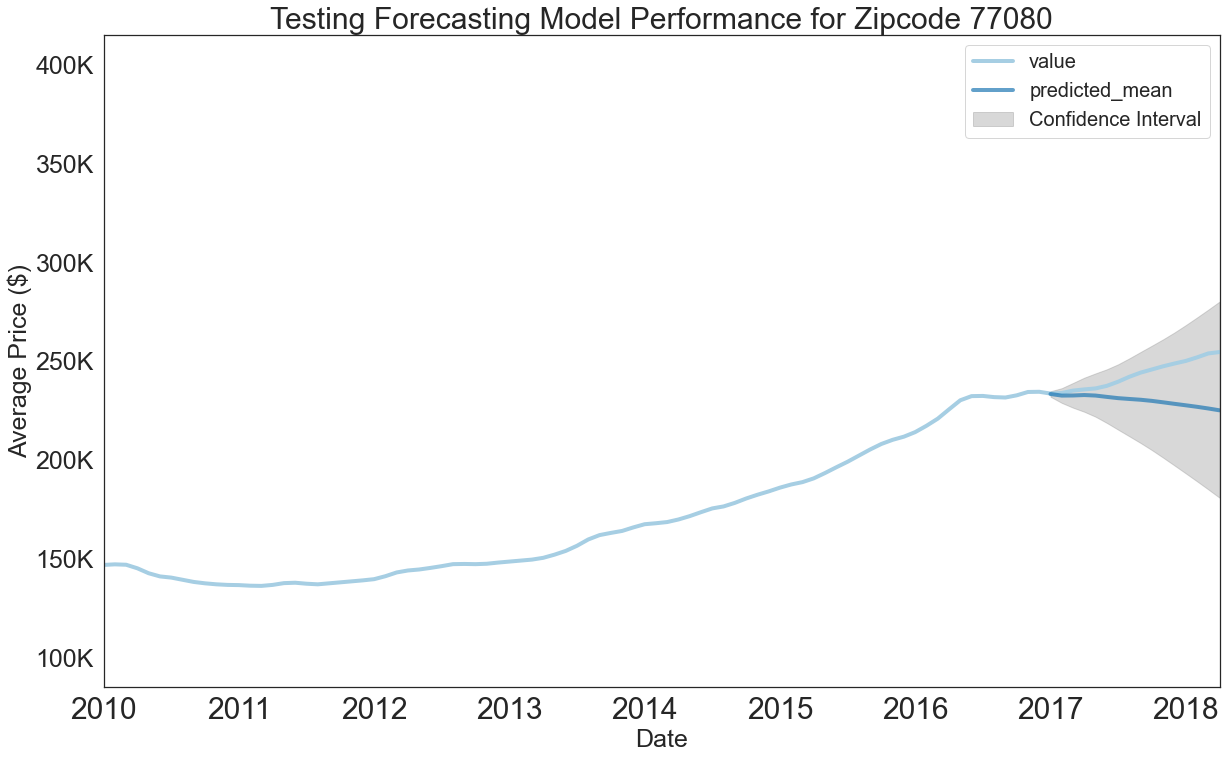

In [62]:
ax = Zip_77080_melted.plot(label='Observed', linewidth=4)
pred_mean_77080.plot(ax=ax, label='Prediction', alpha=.7, figsize=(20, 12), linewidth=4)
ax.fill_between(pred_ci_77080.index,
                pred_ci_77080.iloc[:, 0],
                pred_ci_77080.iloc[:, 1], color='gray', alpha=0.3,label = 'Confidence Interval')
# Set axes labels
plt.plot([2010, 2018], [100000, 400000])
ax.set_xlabel('Date',fontsize=25)
plt.xticks(fontsize=30)
ax.set_ylabel('Average Price ($)',fontsize=25)
plt.yticks([100000,150000,200000,250000,300000,350000, 400000], 
           ["100K", "150K", "200K", "250K", "300K", "350K", "400K"], fontsize = 25)
ax.set_title('Testing Forecasting Model Performance for Zipcode 77080',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [63]:
diff_77080 = round(100*(pred_mean_77080.iloc[-1][0] - Zip_77080_melted.iloc[-1][0])/Zip_77080_melted.iloc[-1][0],1)
print(f'The difference between actual and predicted value in 2018 is: {diff_77080}%')


The difference between actual and predicted value in 2018 is: -11.6%


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0305      0.034      0.885      0.376      -0.037       0.098
ar.L2          0.0295      0.025      1.173      0.241      -0.020       0.079
sigma2      4.676e+05   5.43e+04      8.617      0.000    3.61e+05    5.74e+05


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


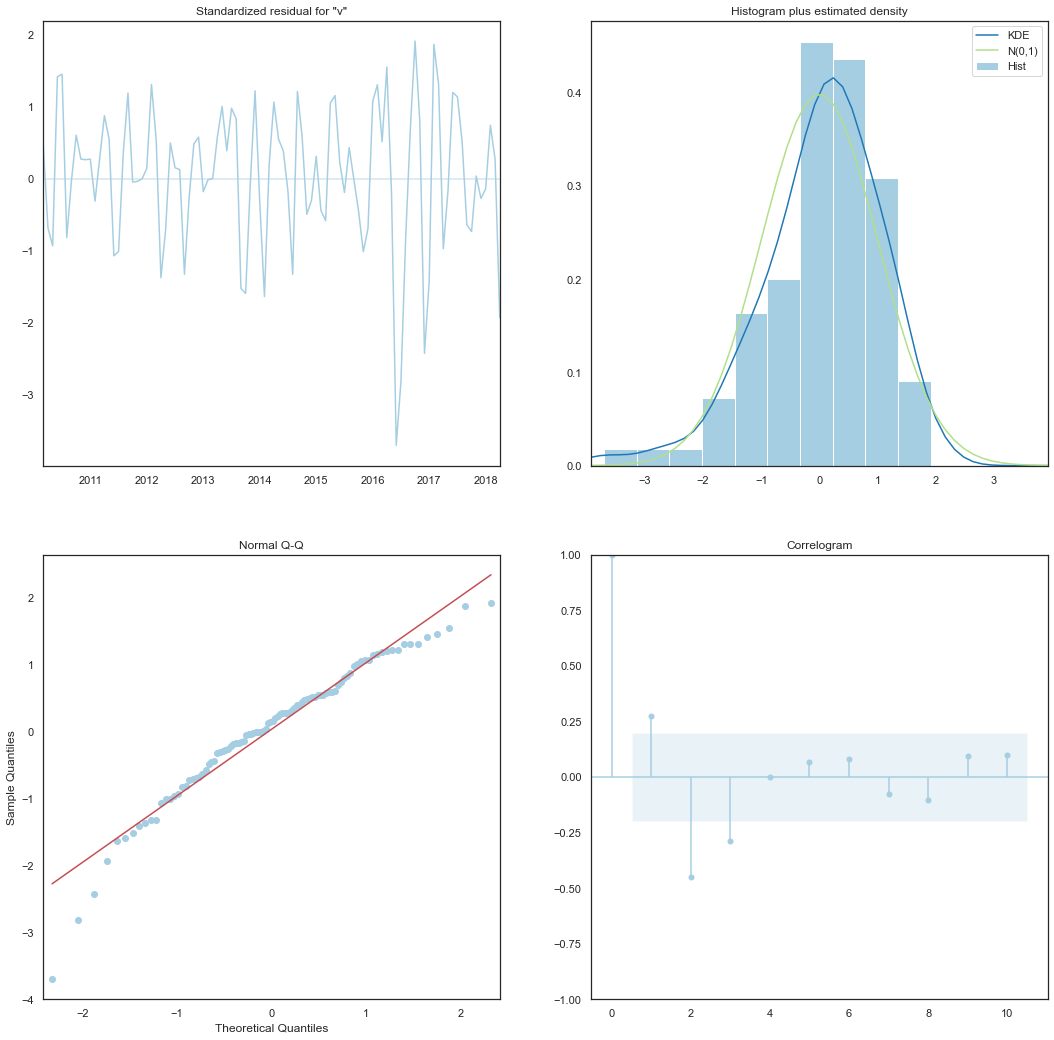

In [64]:
forecast_model_77080 = sm.tsa.statespace.SARIMAX(Zip_77080_melted, 
                                        order=(2,2,0), 
                                        seasonal_order=(0, 0, 0, 12), 
#                                        enforce_stationarity=False, 
#                                        enforce_invertibility=False
)
# Fit the model and print results
forecast_output_77080 = forecast_model_77080.fit()

print(forecast_output_77080.summary().tables[1])
forecast_output_77080.plot_diagnostics(figsize=(18,18))
plt.show()

In [65]:
## Getting a forecast for the next 60 months after the last recorded date on our dataset.
forecast_77080 = forecast_output_77080.get_forecast(60)
future_prediction_77080 = forecast_77080.conf_int()
future_prediction_77080['value'] = forecast_77080.predicted_mean
future_prediction_77080.columns = ['lower','upper','prediction'] 
future_prediction_77080

,lower,upper,prediction
2018-05-01,253926.025215,256606.438485,255266.231850
2018-06-01,252859.637499,258926.494212,255893.065856
2018-07-01,251382.728856,261652.673111,256517.700984
2018-08-01,249567.082073,264715.130424,257141.106248
2018-09-01,247455.632228,268073.185943,257764.409086
2018-10-01,245077.908637,271697.436363,258387.672500
2018-11-01,242455.903014,275565.960363,259010.931688
2018-12-01,239606.852793,279661.526375,259634.189584
2019-01-01,236544.763722,283970.130910,260257.447316
2019-02-01,233281.317309,288480.092700,260880.705005


In [66]:
five_yr_return_77080 = (future_prediction_77080.iloc[-1,2]-Zip_77080_melted.iloc[-1])*100/Zip_77080_melted.iloc[-1]
round(five_yr_return_77080[0],2)

14.71

# Zipcode 78758

In [67]:
auto_model_78758 = pm.auto_arima(Train_set_78758, start_p=0, start_q=0,
#                     test='adf',
                     max_p=5, max_q=10,
                     m=12,
                     d=None,
                     trend = 't',
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=None,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True, with_intercept = True)



print(auto_model_78758.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=-705.004, Time=0.15 sec
 ARIMA(1,2,0)(1,0,0)[12] intercept   : AIC=-731.639, Time=0.22 sec
 ARIMA(0,2,1)(0,0,1)[12] intercept   : AIC=-744.387, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-705.004, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=-731.168, Time=0.05 sec
 ARIMA(0,2,1)(1,0,1)[12] intercept   : AIC=-743.255, Time=0.22 sec
 ARIMA(0,2,1)(0,0,2)[12] intercept   : AIC=-727.168, Time=0.29 sec
 ARIMA(0,2,1)(1,0,0)[12] intercept   : AIC=-745.235, Time=0.26 sec
 ARIMA(0,2,1)(2,0,0)[12] intercept   : AIC=-745.418, Time=1.68 sec
 ARIMA(0,2,1)(2,0,1)[12] intercept   : AIC=-740.845, Time=0.63 sec
 ARIMA(0,2,0)(2,0,0)[12] intercept   : AIC=-710.935, Time=0.45 sec
 ARIMA(1,2,1)(2,0,0)[12] intercept   : AIC=-741.004, Time=1.28 sec
 ARIMA(0,2,2)(2,0,0)[12] intercept   : AIC=-741.943, Time=1.37 sec
 ARIMA(1,2,0)(2,0,0)[12] intercept   : AIC=-729.570, Time=0.61 sec
 ARIMA(1,2,2)(2,0,0

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       9.469e-07   7.77e-06      0.122      0.903   -1.43e-05    1.62e-05
ma.L1          0.7193      0.089      8.042      0.000       0.544       0.895
ar.S.L12      -0.5327      0.104     -5.121      0.000      -0.737      -0.329
sigma2      5.426e-06   9.26e-07      5.857      0.000    3.61e-06    7.24e-06

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


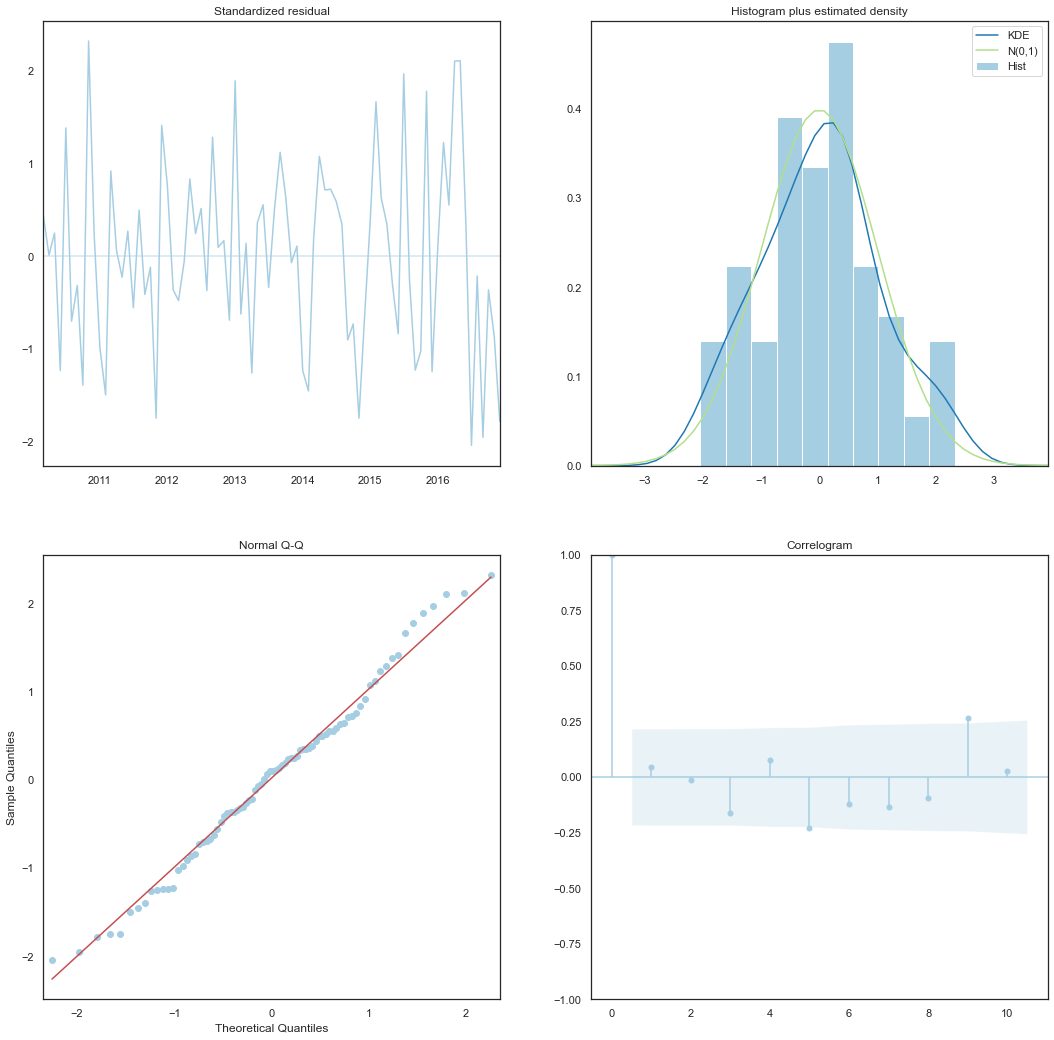

In [68]:
# plug in parameters from the best model from auto ARIMA
# ARIMA(0,2,1)(1,0,0)[12]

ARIMA_MODEL_78758 = sm.tsa.statespace.SARIMAX(Train_set_78758, 
                                        order=(0,2,1), 
                                        seasonal_order=(1, 0, 0, 12), 
                                        trend = 't',
                                        seasonal = True,
                                        trace=True,
                                        error_action= 'ignore',
                                        suppress_warnings=True,
                                        stepwise=True
#                                        enforce_stationarity=False, 
#                                        enforce_invertibility=False)
)
# Fit the model and print results
output_78758 = ARIMA_MODEL_78758.fit(method='powell', disp=False)

print(output_78758.summary().tables[1])
auto_model_78758.plot_diagnostics(figsize=(18,18))
plt.show()


In [69]:
pred_78758 = output_78758.get_prediction(start='2017-01-01',  end='2018-04-01', dynamic=False)
pred_ci_78758 = np.exp(pred_78758.conf_int())
pred_mean_78758 = np.exp(pred_78758.predicted_mean.to_frame())


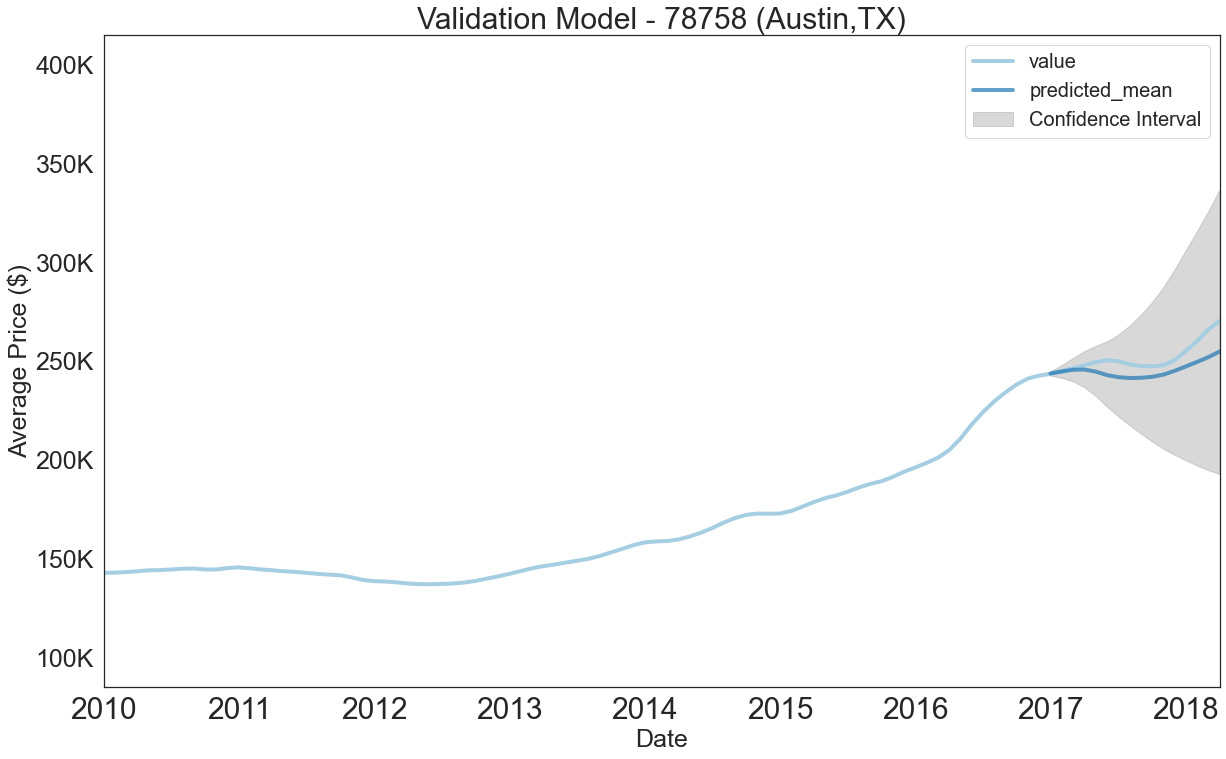

In [70]:
ax = Zip_78758_melted.plot(label='Observed', linewidth=4)
pred_mean_78758.plot(ax=ax, label='Prediction', alpha=.7, figsize=(20, 12), linewidth=4)
ax.fill_between(pred_ci_78758.index,
                pred_ci_78758.iloc[:, 0],
                pred_ci_78758.iloc[:, 1], color='gray', alpha=0.3,label = 'Confidence Interval')
# Set axes labels
plt.plot([2010, 2018], [100000, 400000])
plt.xticks(fontsize=30)
plt.yticks([100000,150000,200000,250000,300000,350000, 400000], 
           ["100K", "150K", "200K", "250K", "300K", "350K", "400K"], fontsize = 25)
ax.set_xlabel('Date',fontsize=25)
ax.set_ylabel('Average Price ($)',fontsize=25)
ax.set_title('Validation Model - 78758 (Austin,TX)',fontsize=30)
plt.legend(fontsize = 20)

plt.show()


In [71]:
diff_78758 = round(100*(pred_mean_78758.iloc[-1][0] - Zip_78758_melted.iloc[-1][0])/Zip_78758_melted.iloc[-1][0],1)
print(f'The difference between actual and predicted value in 2018 is: {diff_78758}%')

The difference between actual and predicted value in 2018 is: -5.7%


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0105      0.021      0.506      0.613      -0.030       0.051
ar.S.L12       0.0126      0.027      0.475      0.634      -0.039       0.065
sigma2      4.563e+05   5.29e+04      8.626      0.000    3.53e+05     5.6e+05


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


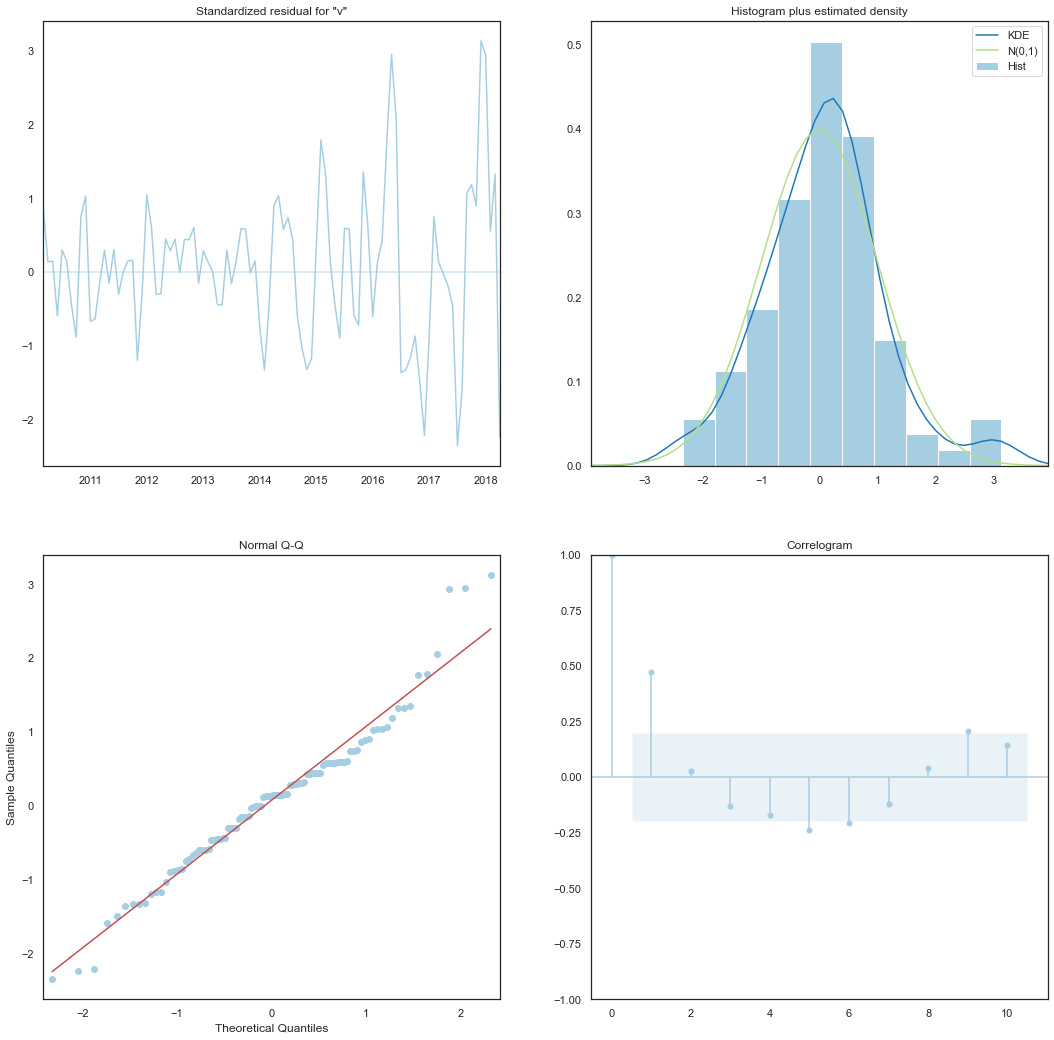

In [72]:
# ARIMA(0,2,1)(1,0,0)[12]
forecast_model_78758 = sm.tsa.statespace.SARIMAX(Zip_78758_melted, 
                                        order=(0,2,1), 
                                        seasonal_order=(1, 0, 0, 12), 
#                                        enforce_stationarity=False, 
#                                        enforce_invertibility=False
)
# Fit the model and print results
forecast_output_78758 = forecast_model_78758.fit()

print(forecast_output_78758.summary().tables[1])
forecast_output_78758.plot_diagnostics(figsize=(18,18))
plt.show()

In [73]:
## Getting a forecast for the next 60 months after the last recorded date on our dataset.
forecast_78758 = forecast_output_78758.get_forecast(60)
future_prediction_78758 = forecast_78758.conf_int()
future_prediction_78758['value'] = forecast_78758.predicted_mean
future_prediction_78758.columns = ['lower','upper','prediction'] 
future_prediction_78758

,lower,upper,prediction
2018-05-01,273458.925187,276106.889180,274782.907183
2018-06-01,276189.085833,282134.965349,279162.025591
2018-07-01,278537.353536,288504.520849,283520.937193
2018-08-01,280563.497254,295168.415977,287865.956615
2018-09-01,282326.001810,302113.631221,292219.816516
2018-10-01,283851.896423,309315.663215,296583.779819
2018-11-01,285158.309961,316752.331387,300955.320674
2018-12-01,286279.803694,324426.962229,305353.382962
2019-01-01,287227.906245,332325.501269,309776.703757
2019-02-01,287993.135165,340417.017341,314205.076253


In [74]:
five_yr_return_78758 = (future_prediction_78758.iloc[-1,2]-Zip_78758_melted.iloc[-1])*100/Zip_78758_melted.iloc[-1]
round(five_yr_return_78758[0],2)

97.96

# Zipcode 77092

In [75]:
auto_model_77092 = pm.auto_arima(Train_set_77092, start_p=0, start_q=0,
#                     test='adf',
                     max_p=5, max_q=10,
                     m=12,
                     d=None,
                     trend = 't',
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=None,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True, with_intercept = True)



print(auto_model_77092.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=-648.705, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12] intercept   : AIC=-656.252, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[12] intercept   : AIC=-677.958, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-648.705, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=-673.859, Time=0.09 sec
 ARIMA(0,2,1)(1,0,1)[12] intercept   : AIC=-673.548, Time=0.13 sec
 ARIMA(0,2,1)(0,0,2)[12] intercept   : AIC=-669.859, Time=0.65 sec
 ARIMA(0,2,1)(1,0,0)[12] intercept   : AIC=-677.162, Time=0.10 sec
 ARIMA(0,2,1)(1,0,2)[12] intercept   : AIC=-671.469, Time=0.41 sec
 ARIMA(0,2,0)(0,0,1)[12] intercept   : AIC=-653.131, Time=0.09 sec
 ARIMA(1,2,1)(0,0,1)[12] intercept   : AIC=-675.696, Time=0.13 sec


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\pmdarima\arima\_auto_solvers.py:40: RuntimeWarning: invalid value encountered in divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(0,2,2)(0,0,1)[12] intercept   : AIC=-634.783, Time=0.19 sec
 ARIMA(1,2,0)(0,0,1)[12] intercept   : AIC=-656.997, Time=0.16 sec
 ARIMA(1,2,2)(0,0,1)[12] intercept   : AIC=-666.862, Time=0.52 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-677.958, Time=0.20 sec

Best model:  ARIMA(0,2,1)(0,0,1)[12] intercept
Total fit time: 3.034 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(0, 2, 1)x(0, 0, 1, 12)   Log Likelihood                 342.979
Date:                            Mon, 31 Oct 2022   AIC                           -677.958
Time:                                    20:16:31   BIC                           -668.332
Sample:                                01-01-2010   HQIC                          -674.093
                                     - 12-01-2016                                         
Covariance Type: 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       3.293e-06   6.23e-06      0.528      0.597   -8.92e-06    1.55e-05
ma.L1          0.7241      0.084      8.670      0.000       0.560       0.888
ma.S.L12      -0.8585      0.328     -2.618      0.009      -1.501      -0.216
sigma2      1.009e-05    3.2e-06      3.152      0.002    3.82e-06    1.64e-05

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


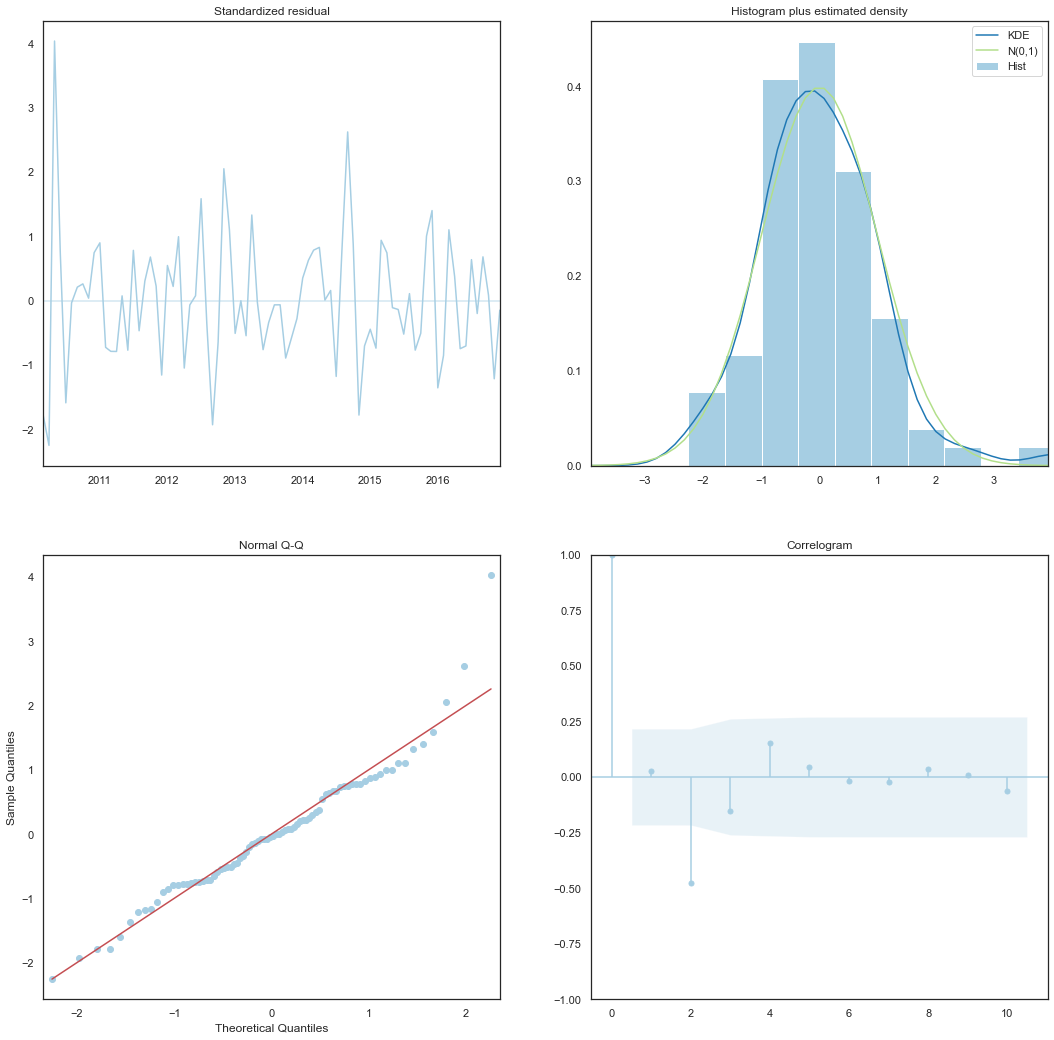

In [76]:
# Enter parameters for best model from auto ARIMA
# (0,2,1)(0,0,1)[12]

ARIMA_MODEL_77092 = sm.tsa.statespace.SARIMAX(Train_set_77092, 
                                        order=(0,2,1), 
                                        seasonal_order=(0, 0, 1, 12), 
                                        trend = 't',
                                        seasonal = True,
                                        trace=True,
                                        error_action= 'ignore',
                                        suppress_warnings=True,
                                        stepwise=True
#                                        enforce_stationarity=False, 
#                                        enforce_invertibility=False)
)
# Fit the model and print results
output_77092 = ARIMA_MODEL_77092.fit(method='powell', disp=False)

print(output_77092.summary().tables[1])
auto_model_77092.plot_diagnostics(figsize=(18,18))
plt.show()

In [77]:
pred_77092 = output_77092.get_prediction(start='2017-01-01',  end='2018-04-01', dynamic=False)
pred_ci_77092 = np.exp(pred_77092.conf_int())
pred_mean_77092 = np.exp(pred_77092.predicted_mean.to_frame())

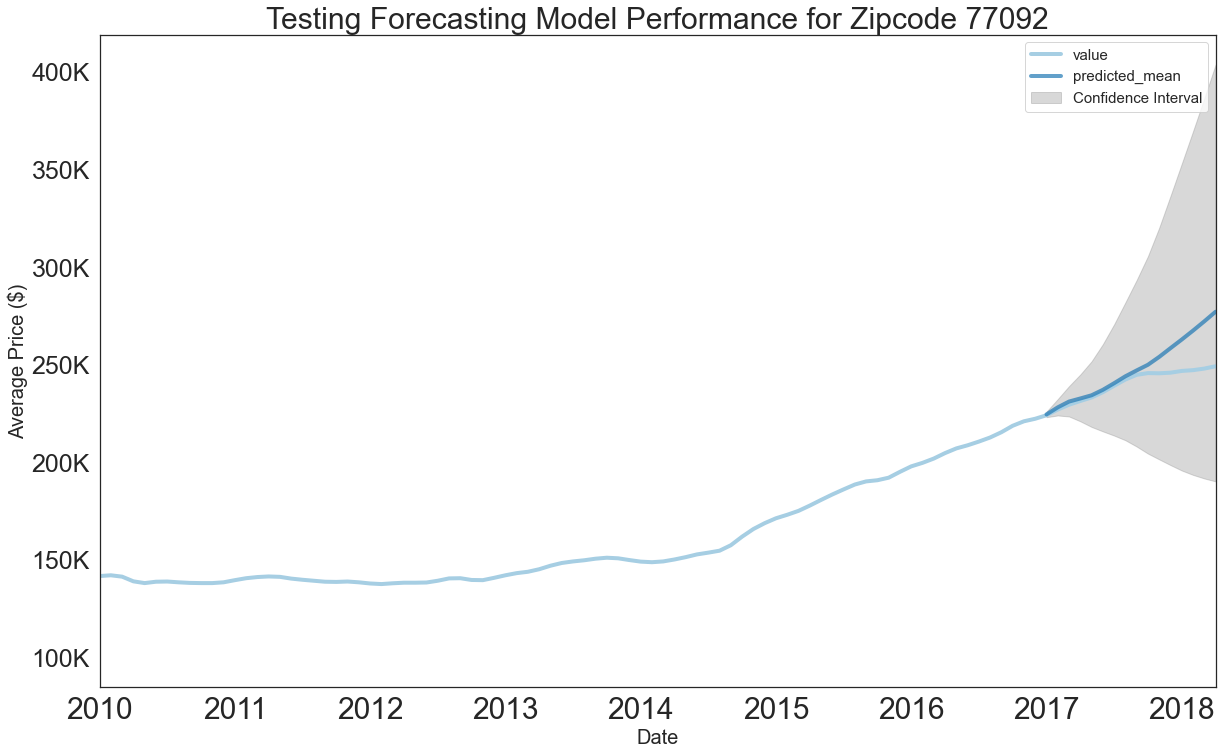

In [78]:
ax = Zip_77092_melted.plot(label='Observed', linewidth=4)
pred_mean_77092.plot(ax=ax, label='Prediction', alpha=.7, figsize=(20, 12), linewidth=4)

ax.fill_between(pred_ci_77092.index,
                pred_ci_77092.iloc[:, 0],
                pred_ci_77092.iloc[:, 1], color='gray', alpha=0.3,label = 'Confidence Interval')
# Set axes labels
plt.plot([2010, 2018], [100000, 400000])
ax.set_xlabel('Date',fontsize=20)
plt.xticks(fontsize=30)
ax.set_ylabel('Average Price ($)',fontsize=20)
plt.yticks([100000,150000,200000,250000,300000,350000, 400000], 
           ["100K", "150K", "200K", "250K", "300K", "350K", "400K"], fontsize = 25)
ax.set_title('Testing Forecasting Model Performance for Zipcode 77092',fontsize=30)
plt.legend(loc='best', fontsize = 15)
plt.show()


In [79]:
diff_77092 = round(100*(pred_mean_77092.iloc[-1][0] - Zip_77092_melted.iloc[-1][0])/Zip_77092_melted.iloc[-1][0],1)
print(f'The difference between actual and predicted value in 2018 is: {diff_77092}%')

The difference between actual and predicted value in 2018 is: 11.2%


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0443      0.034      1.316      0.188      -0.022       0.110
ma.S.L12      -0.0055      0.031     -0.177      0.860      -0.066       0.055
sigma2      3.567e+05   3.87e+04      9.227      0.000    2.81e+05    4.32e+05


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


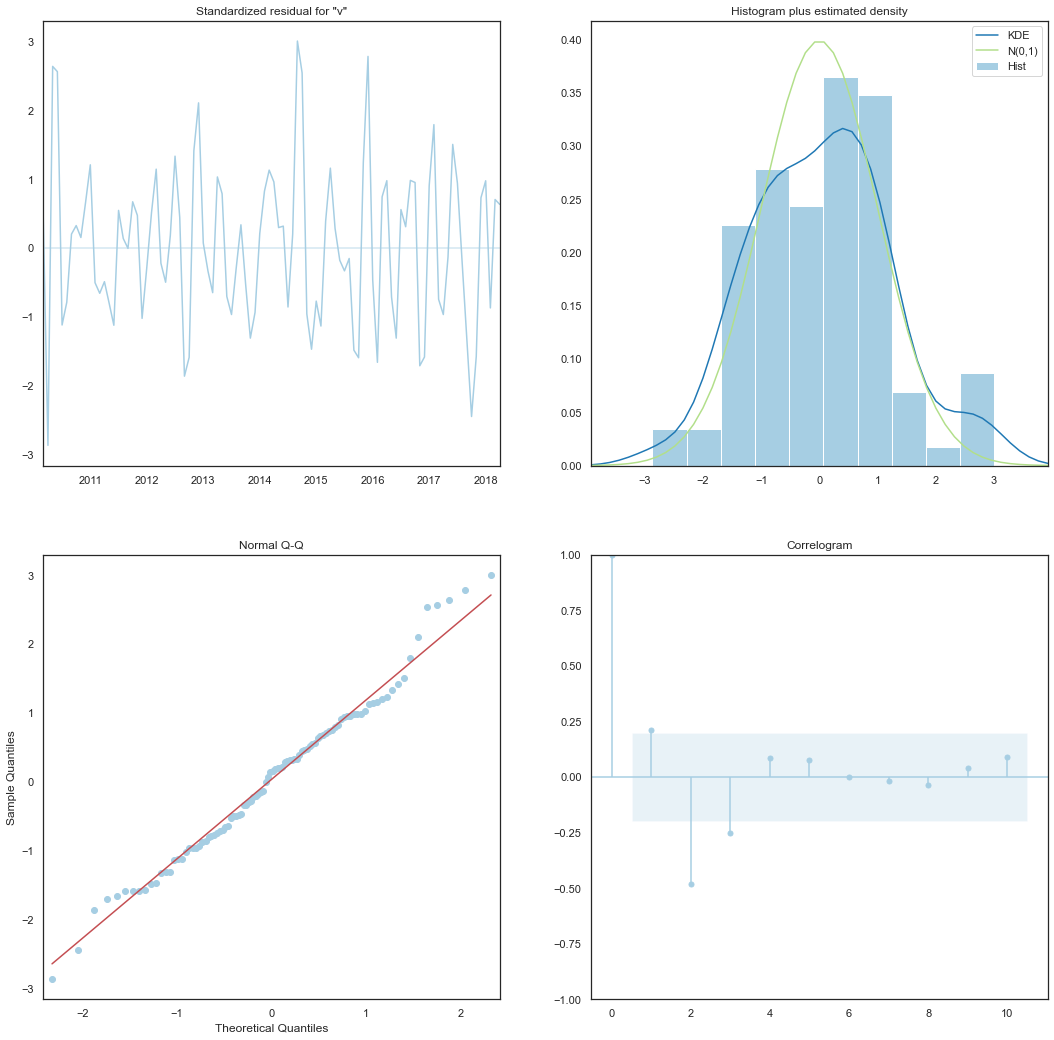

In [80]:
forecast_model_77092 = sm.tsa.statespace.SARIMAX(Zip_77092_melted, 
                                        order=(0,2,1), 
                                        seasonal_order=(0, 0, 1, 12), 
#                                        enforce_stationarity=False, 
#                                        enforce_invertibility=False
)
# Fit the model and print results
forecast_output_77092 = forecast_model_77092.fit()

print(forecast_output_77092.summary().tables[1])
forecast_output_77092.plot_diagnostics(figsize=(18,18))
plt.show()

In [81]:
## Getting a forecast for the next 60 months after the last recorded date on our dataset.
forecast_77092 = forecast_output_77092.get_forecast(60)
future_prediction_77092 = forecast_77092.conf_int()
future_prediction_77092['value'] = forecast_77092.predicted_mean
future_prediction_77092.columns = ['lower','upper','prediction'] 
future_prediction_77092

,lower,upper,prediction
2018-05-01,249346.707593,251687.911674,250517.309633
2018-06-01,249065.665229,254393.716183,251729.690706
2018-07-01,248447.774231,257429.747486,252938.760859
2018-08-01,247547.247375,260749.503190,254148.375282
2018-09-01,246401.145963,264323.602390,255362.374176
2018-10-01,245037.146021,268132.073455,256584.609738
2018-11-01,243470.670026,272154.087141,257812.378584
2018-12-01,241708.392742,276367.559627,259037.976185
2019-01-01,239760.932789,280759.580827,260260.256808
2019-02-01,237644.180654,285326.331034,261485.255844


In [82]:
five_yr_return_77092 = (future_prediction_77092.iloc[-1,2]-Zip_77092_melted.iloc[-1])*100/Zip_77092_melted.iloc[-1]
round(five_yr_return_77092[0],2)


29.37

Plotting our 5 yr Forecasts

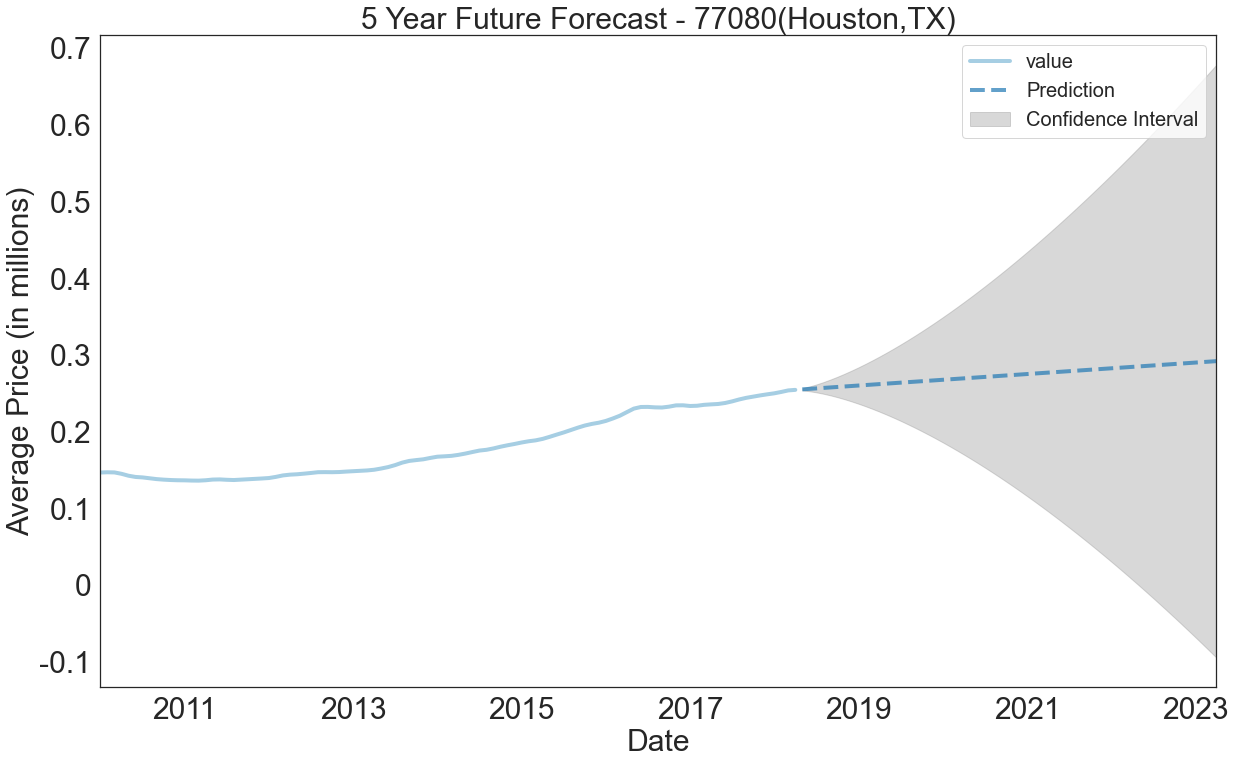

In [83]:
#Zipcode 77080
forecast_77080_mean = forecast_77080.predicted_mean.to_frame()
ax = Zip_77080_melted.plot(label='Observed', linewidth=4)
forecast_77080.predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(20, 12), linewidth=4, linestyle = "dashed")
ax.fill_between(future_prediction_77080.index,
                future_prediction_77080.iloc[:, 0],
                future_prediction_77080.iloc[:, 1], color='gray', alpha=0.3,label = 'Confidence Interval')
# Set axes labels
ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Average Price (in millions)',fontsize=30)
plt.yticks(fontsize=30)
#Changing the y scale to ($) Millions
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('5 Year Future Forecast - 77080(Houston,TX)',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

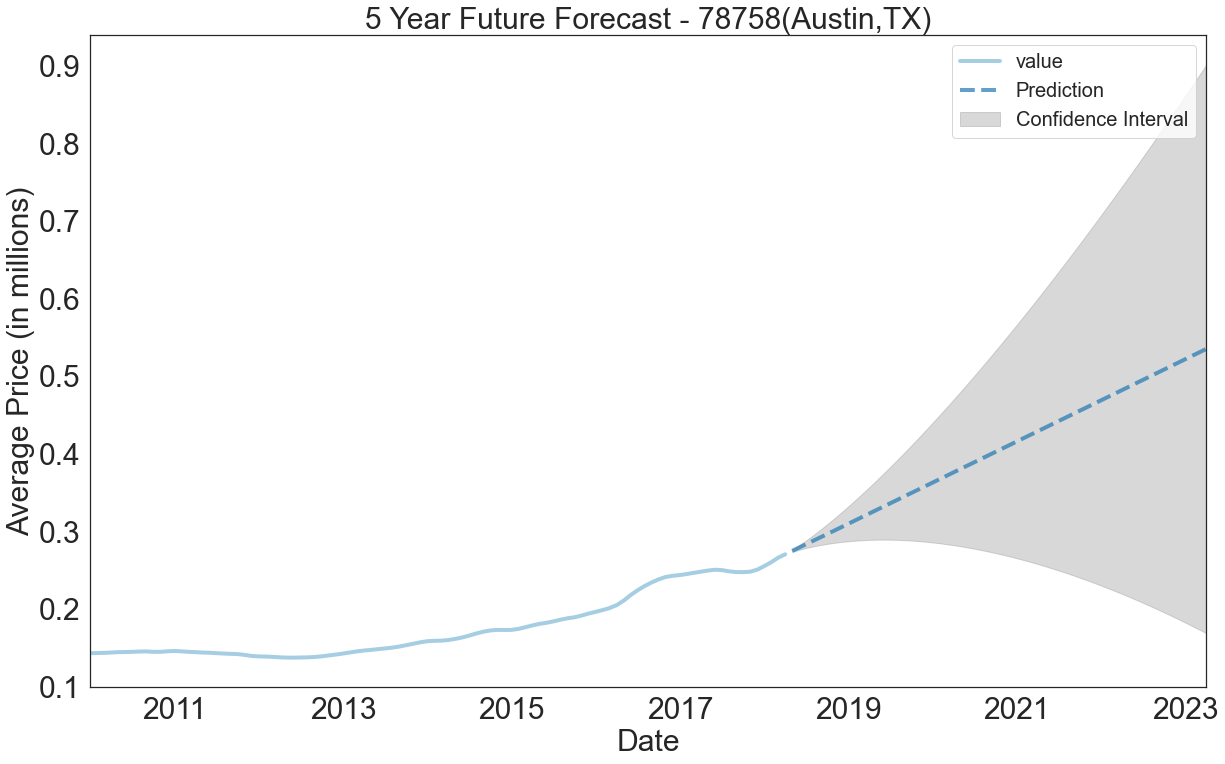

In [84]:
#Zipcode 78758
forecast_78758_mean = forecast_78758.predicted_mean.to_frame()
ax = Zip_78758_melted.plot(label='Observed', linewidth=4)
forecast_78758.predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(20, 12), linewidth=4, linestyle = "dashed")
ax.fill_between(future_prediction_78758.index,
                future_prediction_78758.iloc[:, 0],
                future_prediction_78758.iloc[:, 1], color='gray', alpha=0.3,label = 'Confidence Interval')
# Set axes labels
ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Average Price (in millions)',fontsize=30)
plt.yticks(fontsize=30)
#Changing the y scale to ($) Millions
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('5 Year Future Forecast - 78758(Austin,TX)',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

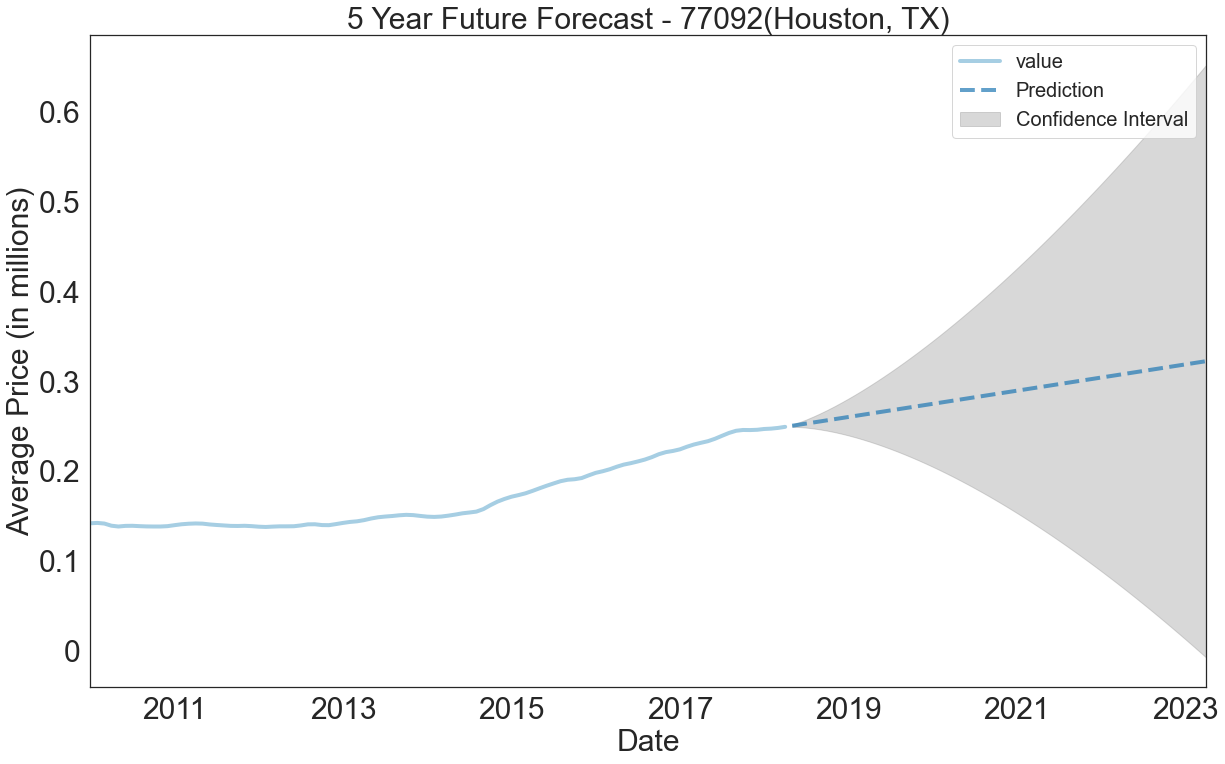

In [85]:
#Zipcode 77092
forecast_77092_mean = forecast_77092.predicted_mean.to_frame()
ax = Zip_77092_melted.plot(label='Observed', linewidth=4)
forecast_77092.predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(20, 12), linewidth=4, linestyle = "dashed")
ax.fill_between(future_prediction_77092.index,
                future_prediction_77092.iloc[:, 0],
                future_prediction_77092.iloc[:, 1], color='gray', alpha=0.3,label = 'Confidence Interval')
# Set axes labels
ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Average Price (in millions)',fontsize=30)
plt.yticks(fontsize=30)
#Changing the y scale to ($) Millions
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('5 Year Future Forecast - 77092(Houston, TX)',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

Our 5 Year Return Predictions
77080: 14.7%
78758: 96.9%
77092: 29.37%